In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
import shap


In [2]:
data = pd.read_csv('final.csv')
data.columns


Index(['GEOID', 'Year', 'RegionName', 'State', 'population', 'poverty.rate',
       'renter.occupied.households', 'pct.renter.occupied',
       'median.gross.rent', 'median.household.income', 'median.property.value',
       'rent.burden', 'pct.white', 'pct.af.am', 'pct.hispanic', 'pct.am.ind',
       'pct.asian', 'pct.nh.pi', 'pct.multiple', 'pct.other',
       'eviction.filings', 'evictions', 'eviction.rate',
       'eviction.filing.rate', 'low.flag', 'imputed', 'subbed', 'RegionID',
       'SizeRank', 'RegionType', 'Metro', 'StateCodeFIPS', 'MunicipalCodeFIPS',
       'ZHVI'],
      dtype='object')

In [3]:
data = pd.read_csv('final.csv')

selected_columns = [
    'poverty.rate', 'pct.renter.occupied', 'median.gross.rent',
    'rent.burden', 'median.household.income', 'eviction.rate', 'population', 'ZHVI'
]

data = data.dropna(subset=selected_columns)

scaler = StandardScaler()
scaled_data = scaler.fit_transform(data[selected_columns])

pca = PCA(n_components=1)
socioeconomic_index = pca.fit_transform(scaled_data)

data['SEIFA'] = socioeconomic_index

data[['GEOID', 'Year', 'RegionName', 'State', 'SEIFA']]

GEOID  Year       RegionName    State     SEIFA
1       1001  2008   Autauga County  Alabama  1.454775
2       1001  2009   Autauga County  Alabama  1.346155
3       1001  2011   Autauga County  Alabama  1.982927
4       1001  2012   Autauga County  Alabama  2.082995
5       1001  2013   Autauga County  Alabama  2.146471
...      ...   ...              ...      ...       ...
11683  56041  2016     Uinta County  Wyoming  1.049200
11684  56043  2013  Washakie County  Wyoming  0.246343
11685  56043  2014  Washakie County  Wyoming  0.284856
11686  56043  2015  Washakie County  Wyoming  0.314502
11687  56043  2016  Washakie County  Wyoming  0.387130

[10834 rows x 5 columns]

In [4]:
print(data.columns)

Index(['GEOID', 'Year', 'RegionName', 'State', 'population', 'poverty.rate',
       'renter.occupied.households', 'pct.renter.occupied',
       'median.gross.rent', 'median.household.income', 'median.property.value',
       'rent.burden', 'pct.white', 'pct.af.am', 'pct.hispanic', 'pct.am.ind',
       'pct.asian', 'pct.nh.pi', 'pct.multiple', 'pct.other',
       'eviction.filings', 'evictions', 'eviction.rate',
       'eviction.filing.rate', 'low.flag', 'imputed', 'subbed', 'RegionID',
       'SizeRank', 'RegionType', 'Metro', 'StateCodeFIPS', 'MunicipalCodeFIPS',
       'ZHVI', 'SEIFA'],
      dtype='object')


In [5]:
# data.to_csv('final_with_SEIFA.csv', index=False)

In [6]:
data['Rank'] = data.groupby('Year')['SEIFA'].rank(ascending=False)

data = data.sort_values(['GEOID', 'Year']).reset_index(drop=True)

data['Rank_Change'] = data.groupby('GEOID')['Rank'].diff()

std_dev = data['Rank_Change'].std()
data['Rank_Change_SD'] = std_dev 

data['Classification'] = data['Rank_Change'].apply(
    lambda x: 'Gentrifying' if x > std_dev else 'Not Gentrifying'
)

In [7]:
data

GEOID  Year       RegionName    State  population  poverty.rate  \
0       1001  2008   Autauga County  Alabama     49584.0          7.52   
1       1001  2009   Autauga County  Alabama     49584.0          7.52   
2       1001  2011   Autauga County  Alabama     55221.0          9.28   
3       1001  2012   Autauga County  Alabama     55221.0          9.28   
4       1001  2013   Autauga County  Alabama     55221.0          9.28   
...      ...   ...              ...      ...         ...           ...   
10829  56041  2016     Uinta County  Wyoming     20930.0         10.81   
10830  56043  2013  Washakie County  Wyoming      8400.0         10.08   
10831  56043  2014  Washakie County  Wyoming      8400.0         10.08   
10832  56043  2015  Washakie County  Wyoming      8400.0         10.08   
10833  56043  2016  Washakie County  Wyoming      8400.0         10.08   

       renter.occupied.households  pct.renter.occupied  median.gross.rent  \
0                            4593                22.45              779.0   
1                            4783                22.45              779.0   
2                            5040                26.08              883.0   
3                            5107                26.08              883.0   
4                            5174                26.08              883.0   
...                           ...                  ...                ...   
10829                        2195                26.95              641.0   
10830                         974                26.25              605.0   
10831                         988                26.25              605.0   
10832                        1002                26.25              605.0   
10833                        1016                26.25              605.0   

       median.household.income  ...  RegionType           Metro  \
0                      51463.0  ...      county  Montgomery, AL   
1                      51463.0  ...      county  Montgomery, AL   
2                      51281.0  ...      county  Montgomery, AL   
3                      51281.0  ...      county  Montgomery, AL   
4                      51281.0  ...      county  Montgomery, AL   
...                        ...  ...         ...             ...   
10829                  56569.0  ...      county    Evanston, WY   
10830                  47652.0  ...      county             NaN   
10831                  47652.0  ...      county             NaN   
10832                  47652.0  ...      county             NaN   
10833                  47652.0  ...      county             NaN   

       StateCodeFIPS  MunicipalCodeFIPS          ZHVI     SEIFA   Rank  \
0                  1                  1  1.957993e+06  1.454775  111.0   
1                  1                  1  1.908526e+06  1.346155  129.0   
2                  1                  1  1.771719e+06  1.982927  129.0   
3                  1                  1  1.779735e+06  2.082995  119.0   
4                  1                  1  1.823699e+06  2.146471  110.0   
...              ...                ...           ...       ...    ...   
10829             56                 41  2.258164e+06  1.049200  255.0   
10830             56                 43  1.821669e+06  0.246343  413.0   
10831             56                 43  1.837395e+06  0.284856  407.0   
10832             56                 43  1.905472e+06  0.314502  414.0   
10833             56                 43  2.003173e+06  0.387130  390.0   

       Rank_Change  Rank_Change_SD   Classification  
0              NaN       54.141192  Not Gentrifying  
1             18.0       54.141192  Not Gentrifying  
2              0.0       54.141192  Not Gentrifying  
3            -10.0       54.141192  Not Gentrifying  
4             -9.0       54.141192  Not Gentrifying  
...            ...             ...              ...  
10829         -8.0       54.141192  Not Gentrifying  
10830          NaN       54.141192  Not Gentrifying  
10831        

In [8]:
data.Classification.value_counts()

Classification
Not Gentrifying    9255
Gentrifying        1579
Name: count, dtype: int64

In [9]:
# data.isnull().sum()
# data.dropna(inplace=True)
# data.isnull().sum()


In [10]:
data.Classification.value_counts()


Classification
Not Gentrifying    9255
Gentrifying        1579
Name: count, dtype: int64

In [11]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10834 entries, 0 to 10833
Data columns (total 39 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   GEOID                       10834 non-null  int64  
 1   Year                        10834 non-null  int64  
 2   RegionName                  10834 non-null  object 
 3   State                       10834 non-null  object 
 4   population                  10834 non-null  float64
 5   poverty.rate                10834 non-null  float64
 6   renter.occupied.households  10834 non-null  int64  
 7   pct.renter.occupied         10834 non-null  float64
 8   median.gross.rent           10834 non-null  float64
 9   median.household.income     10834 non-null  float64
 10  median.property.value       10834 non-null  float64
 11  rent.burden                 10834 non-null  float64
 12  pct.white                   10834 non-null  float64
 13  pct.af.am                   108

In [12]:
data.describe()


GEOID          Year    population  poverty.rate  \
count  10834.000000  10834.000000  1.083400e+04  10834.000000   
mean   31546.859609   2008.785398  9.145183e+04     11.906073   
std    15226.732304      4.631018  2.633882e+05      5.523786   
min     1001.000000   2000.000000  4.330000e+02      0.000000   
25%    19165.000000   2005.000000  9.340500e+03      7.990000   
50%    31135.000000   2009.000000  1.985600e+04     10.980000   
75%    42055.000000   2013.000000  5.767375e+04     14.610000   
max    56043.000000   2016.000000  5.257001e+06     45.380000   

       renter.occupied.households  pct.renter.occupied  median.gross.rent  \
count                10834.000000         10834.000000       10834.000000   
mean                 12335.914990            26.650564         580.620639   
std                  41497.401865             6.635779         167.012089   
min                     61.000000             7.350000         178.000000   
25%                    891.000000            22.160000         470.000000   
50%                   1946.500000            25.710000         571.000000   
75%                   6560.250000            29.940000         666.000000   
max                 826101.000000            81.030000        1747.000000   

       median.household.income  median.property.value   rent.burden  ...  \
count             10834.000000           1.083400e+04  10834.000000  ...   
mean              42078.528798           1.125036e+05     26.690927  ...   
std               10392.798266           5.984441e+04      4.709359  ...   
min               15805.000000           2.250000e+04      8.300000  ...   
25%               34843.250000           7.640000e+04     23.600000  ...   
50%               41238.000000           9.850000e+04     26.600000  ...   
75%               48096.750000           1.351500e+05     29.700000  ...   
max              112552.000000           1.000001e+06     50.100000  ...   

             subbed      RegionID      SizeRank  StateCodeFIPS  \
count  10834.000000  10834.000000  10834.000000   10834.000000   
mean       0.000277   1581.948588   1736.207218      31.446557   
std        0.016639    900.661636    954.195734      15.215864   
min        0.000000     67.000000      1.000000       1.000000   
25%        0.000000    794.000000    882.000000      19.000000   
50%        0.000000   1591.000000   1905.000000      31.000000   
75%        0.000000   2338.000000   2565.000000      42.000000   
max        1.000000   3275.000000   3212.000000      56.000000   

       MunicipalCodeFIPS          ZHVI         SEIFA          Rank  \
count       10834.000000  1.083400e+04  1.083400e+04  10834.000000   
mean          100.302474  9.058067e+05  1.574029e-17    331.418682   
std            84.643548  1.028082e+06  1.789343e+00    200.000261   
min             1.000000  0.000000e+00 -4.398317e+00      1.000000   
25%            39.000000  0.000000e+00 -1.230451e+00    160.000000   
50%            85.000000  8.960251e+05 -2.230806e-01    321.000000   
75%           137.000000  1.507763e+06  9.719624e-01    496.000000   
max           505.000000  1.433042e+07  1.077086e+01    763.000000   

       Rank_Change  Rank_Change_SD  
count  9415.000000    10834.000000  
mean     15.830271       54.141192  
std      54.141192        0.000000  
min    -448.000000       54.141192  
25%      -8.000000       54.141192  
50%       9.000000       54.141192  
75%      36.000000       54.141192  
max     490.000000       54.141192  

[8 rows x 34 columns]

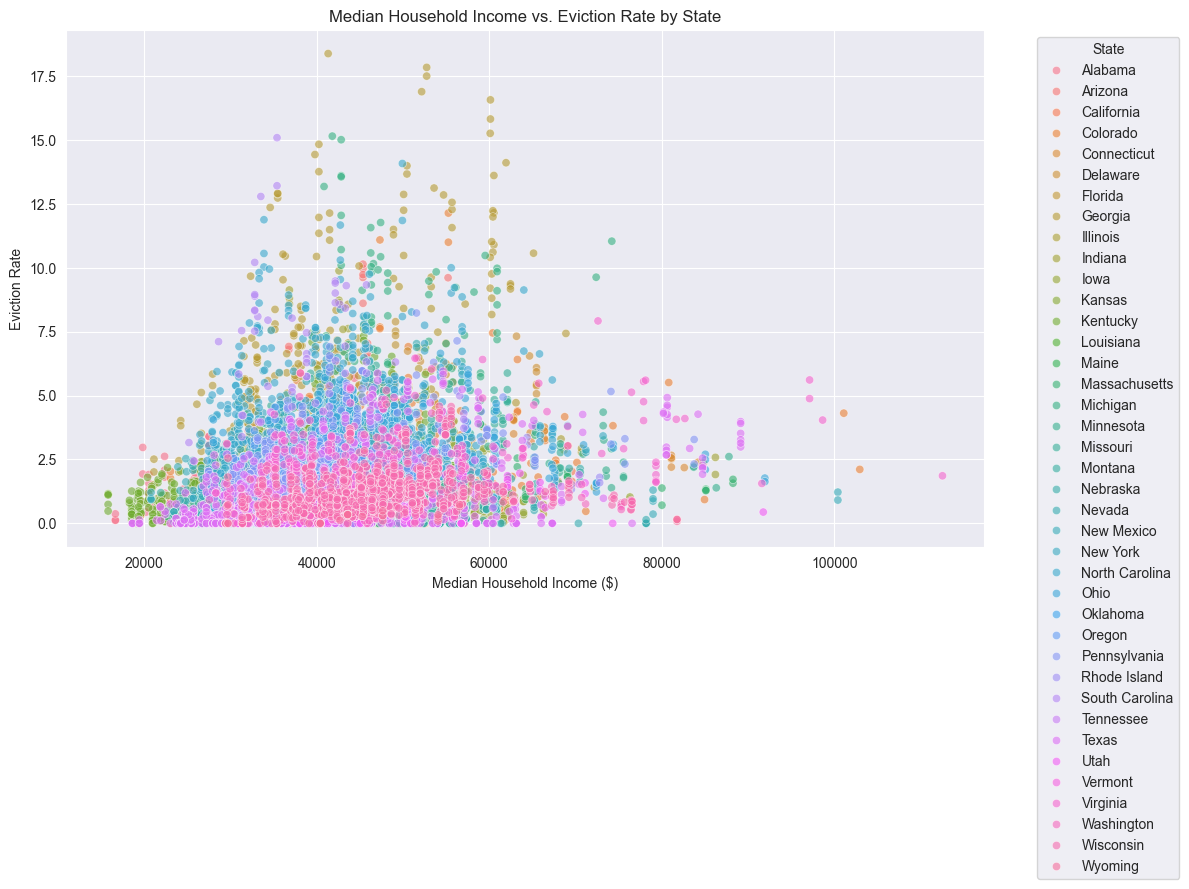

In [13]:
# Scatter Plot of Median Household Income vs. Eviction Rate
plt.figure(figsize=(12, 8))
sns.scatterplot(data=data, x='median.household.income', y='eviction.rate', hue='State', alpha=0.6)
plt.title('Median Household Income vs. Eviction Rate by State')
plt.xlabel('Median Household Income ($)')
plt.ylabel('Eviction Rate')
plt.legend(title='State', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

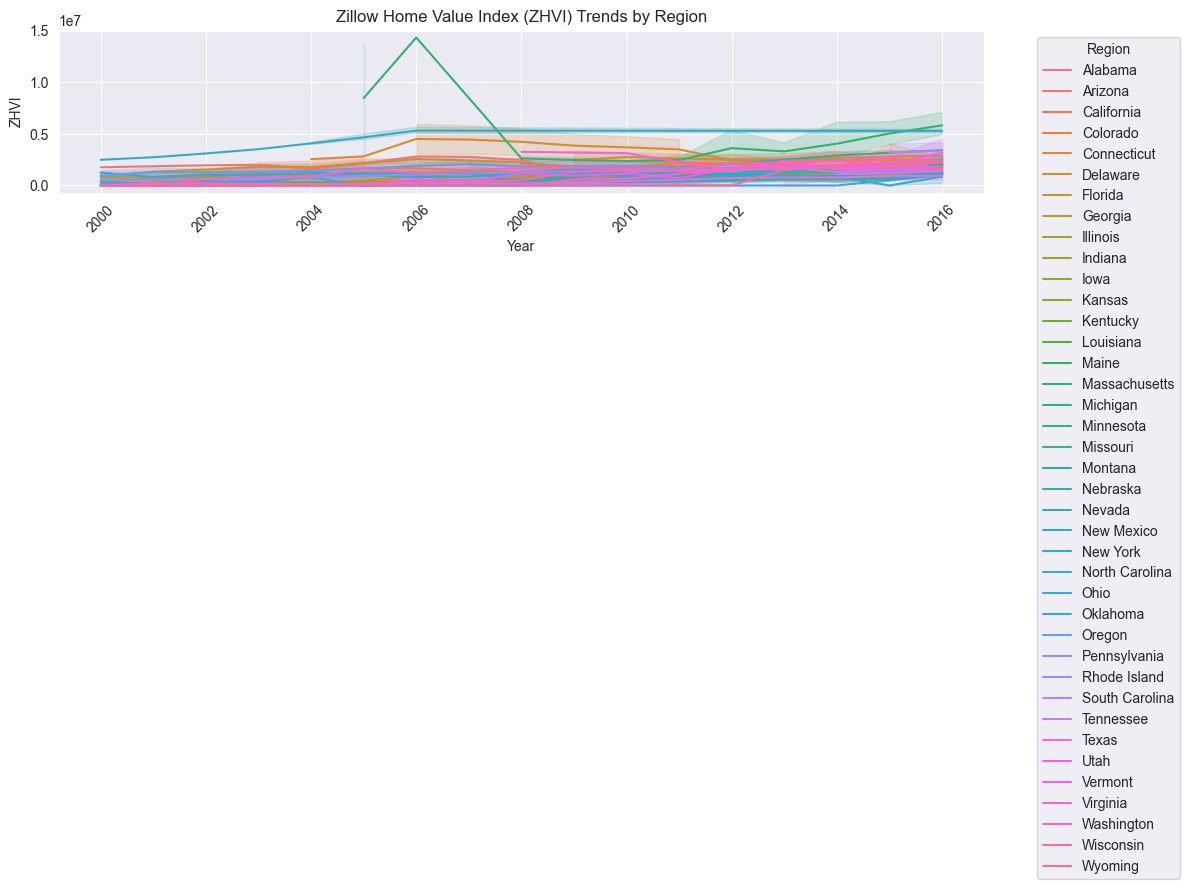

In [14]:
# Time Series Line Plot of ZHVI
plt.figure(figsize=(12, 6))
sns.lineplot(data=data, x='Year', y='ZHVI', hue='State')
plt.title('Zillow Home Value Index (ZHVI) Trends by Region')
plt.ylabel('ZHVI')
plt.xticks(rotation=45)
plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

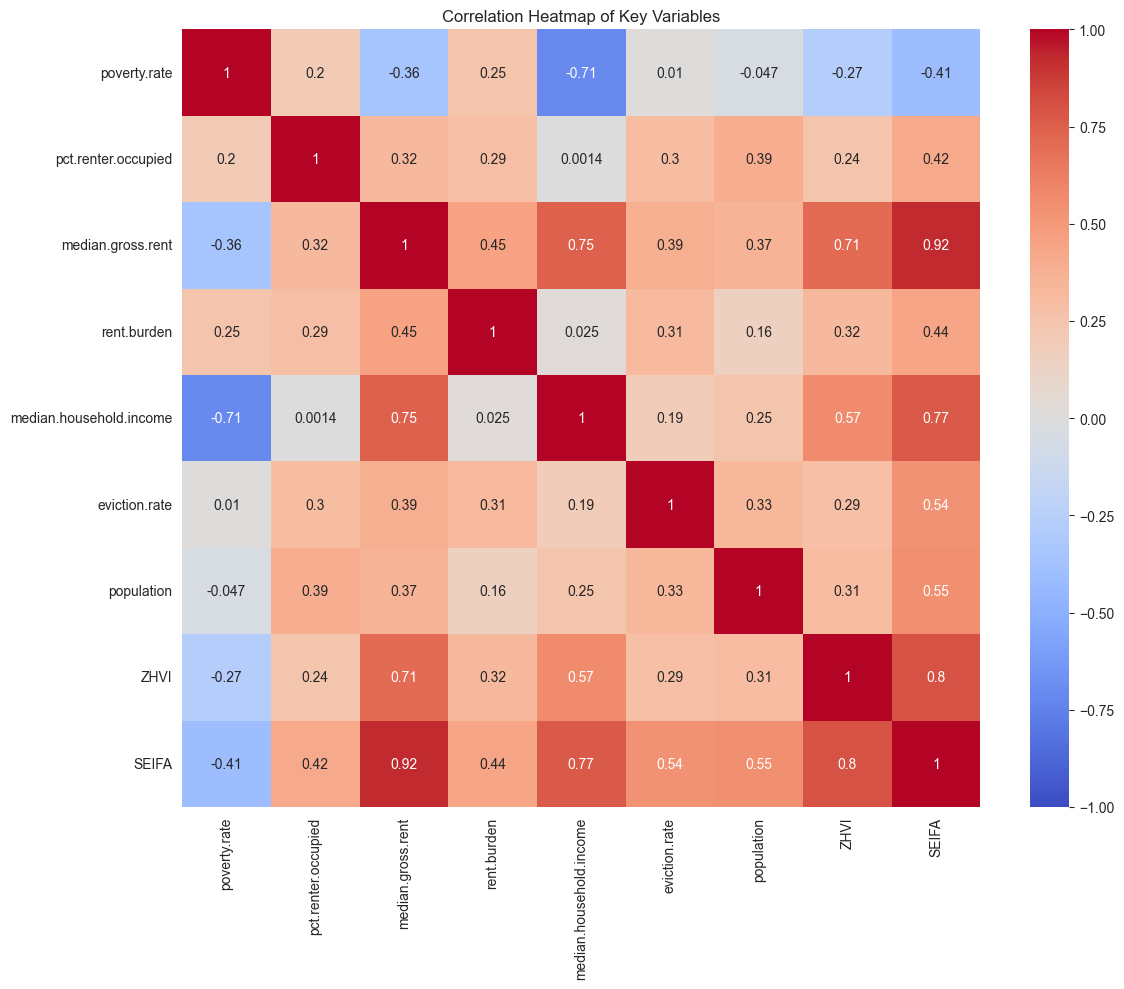

In [15]:
# Heatmap of Correlation Matrix
correlation_matrix = data[['poverty.rate', 'pct.renter.occupied', 'median.gross.rent', 
                           'rent.burden', 'median.household.income', 'eviction.rate', 
                           'population', 'ZHVI', 'SEIFA']].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Heatmap of Key Variables')
plt.tight_layout()
plt.show()

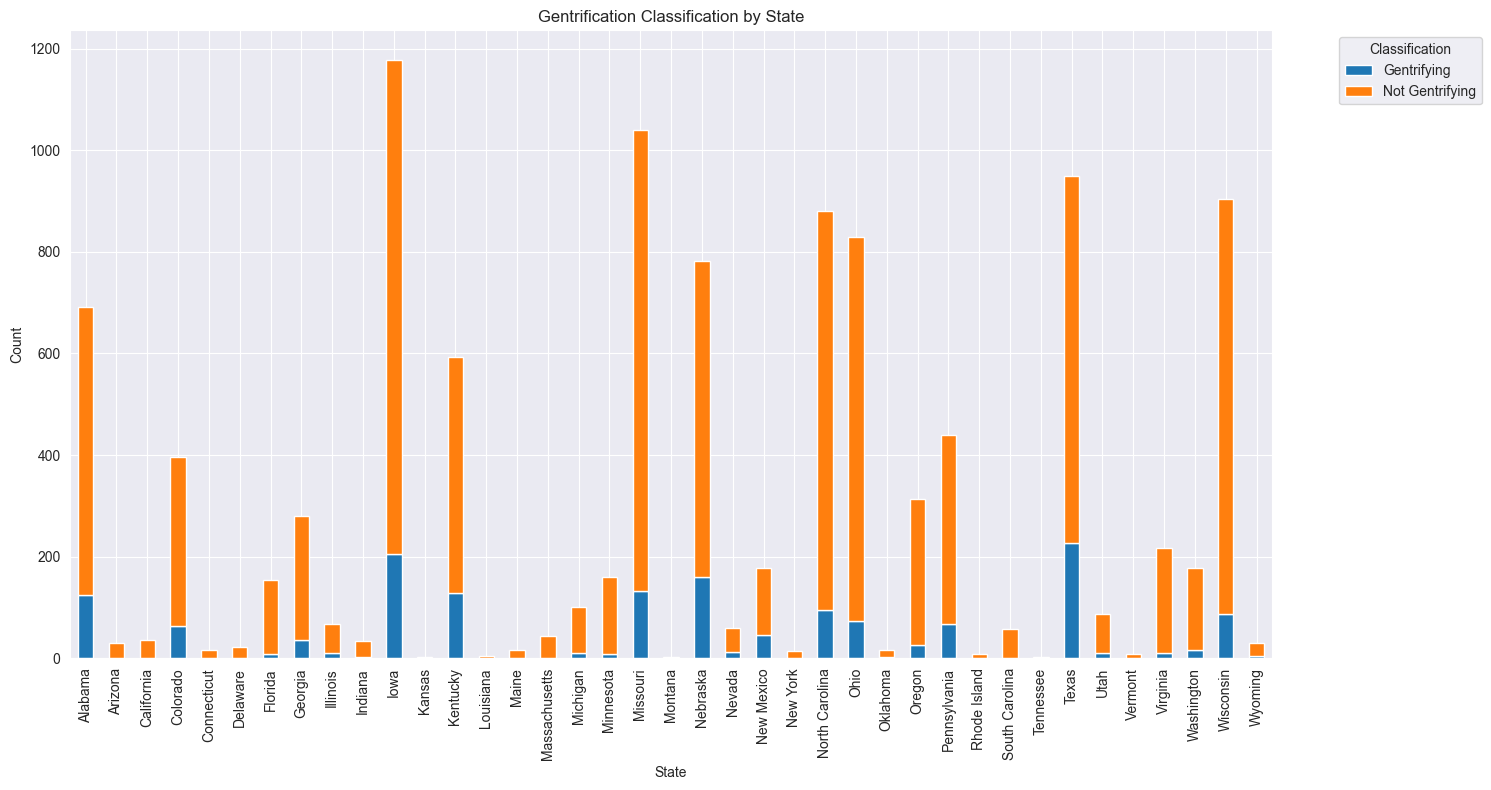

In [16]:
# Bar Plot of Gentrification Classification by State
classification_by_state = data.groupby(['State', 'Classification']).size().unstack()
classification_by_state.plot(kind='bar', stacked=True, figsize=(15, 8))
plt.title('Gentrification Classification by State')
plt.xlabel('State')
plt.ylabel('Count')
plt.legend(title='Classification', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [17]:
# Understand the dataset, identify patterns, and generate hypotheses for modeling.

# Understand Target Variable:
# Distribution of the target variable 'Classification'
data['Classification'].value_counts(normalize=True)

Classification
Not Gentrifying    0.854255
Gentrifying        0.145745
Name: proportion, dtype: float64

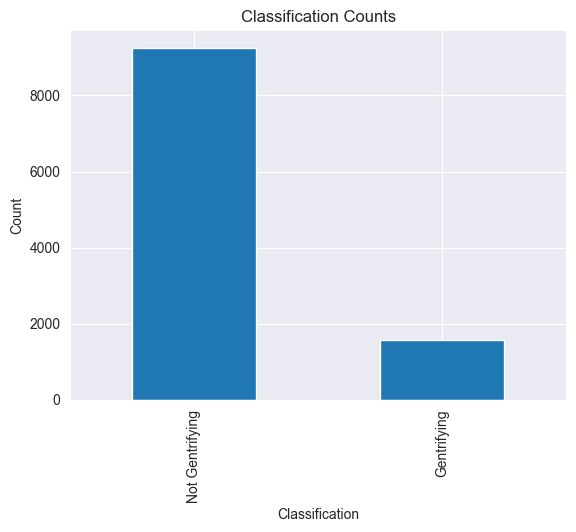

In [18]:
data['Classification'].value_counts().plot(kind='bar', title='Classification Counts')
plt.xlabel('Classification')
plt.ylabel('Count')
plt.show()

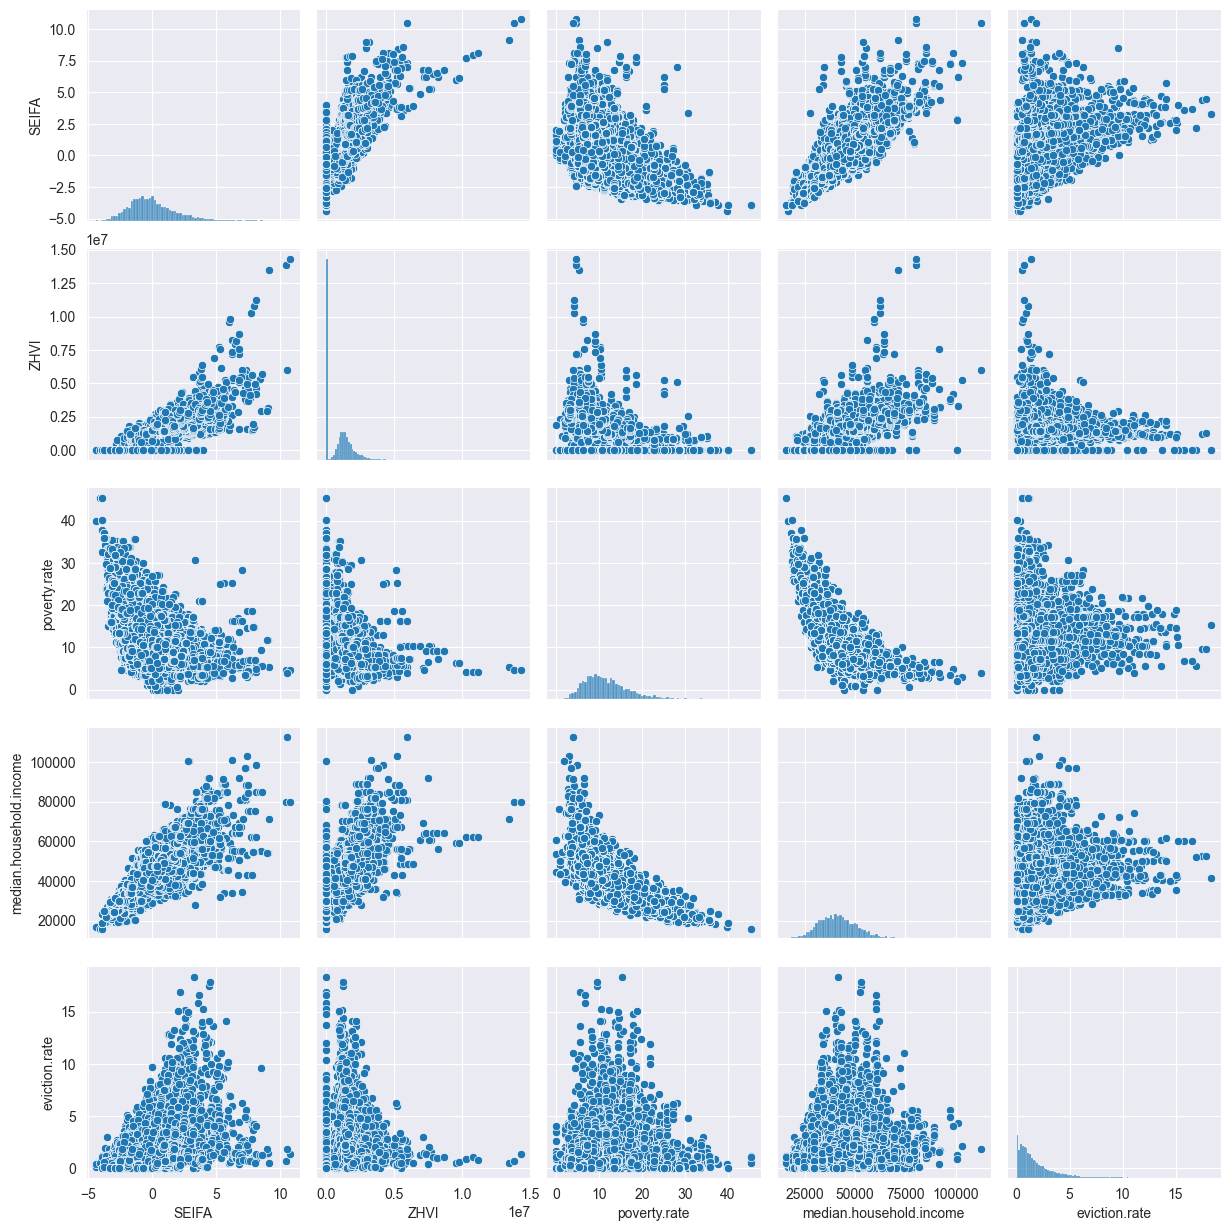

In [19]:
# Feature Relationships: Use pair plots or scatter plots to explore relationships between SEIFA, ZHVI, and other socioeconomic factors.
sns.pairplot(data[['SEIFA', 'ZHVI', 'poverty.rate', 'median.household.income', 'eviction.rate']])
plt.show()

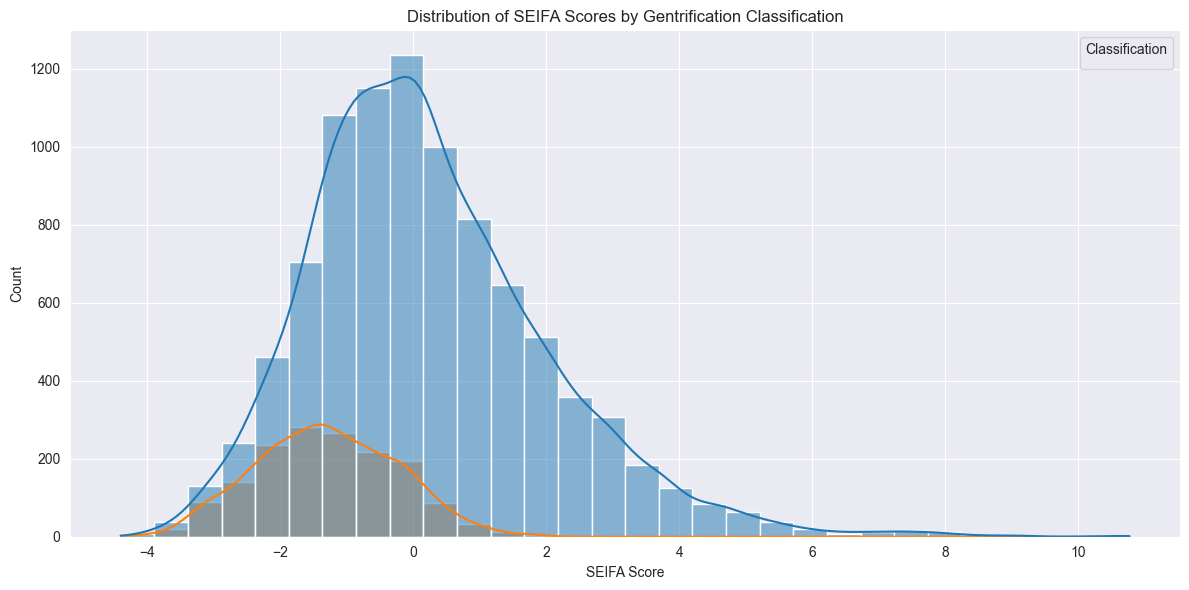

In [20]:
# Distribution of SEIFA Scores by Gentrification Classification
plt.figure(figsize=(12, 6))
sns.histplot(data=data, x='SEIFA', hue='Classification', kde=True, bins=30)
plt.title('Distribution of SEIFA Scores by Gentrification Classification')
plt.xlabel('SEIFA Score')
plt.ylabel('Count')
plt.legend(title='Classification')
plt.tight_layout()
plt.show()

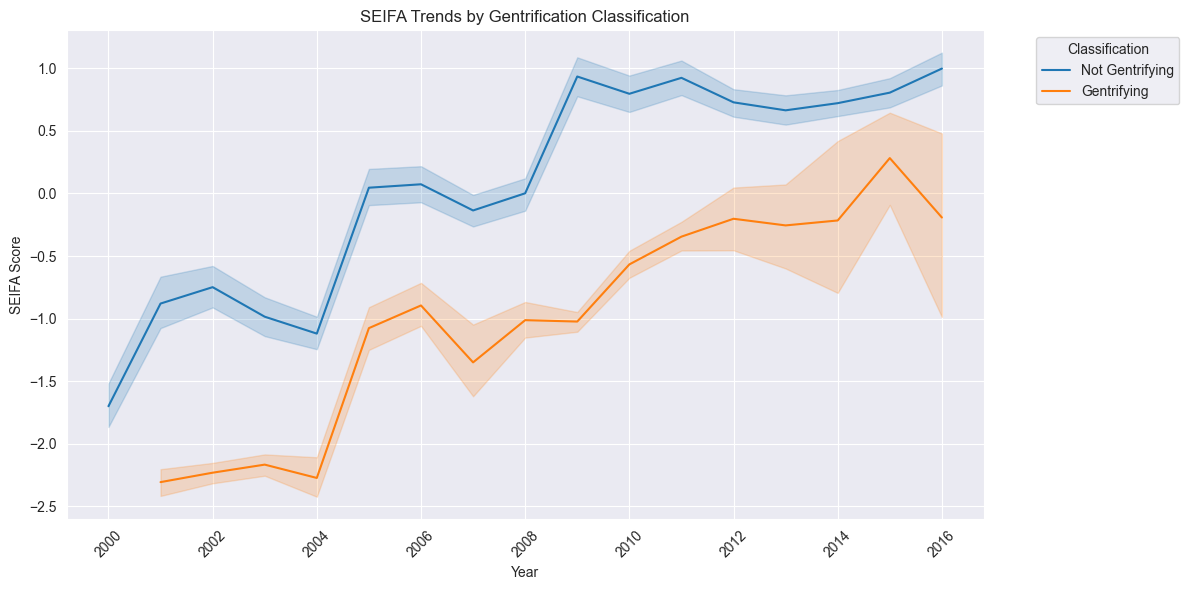

In [21]:
# Analyze how key variables like ZHVI, SEIFA, or eviction.rate change over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=data, x='Year', y='SEIFA', hue='Classification')
plt.title('SEIFA Trends by Gentrification Classification')
plt.ylabel('SEIFA Score')
plt.xticks(rotation=45)
plt.legend(title='Classification', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

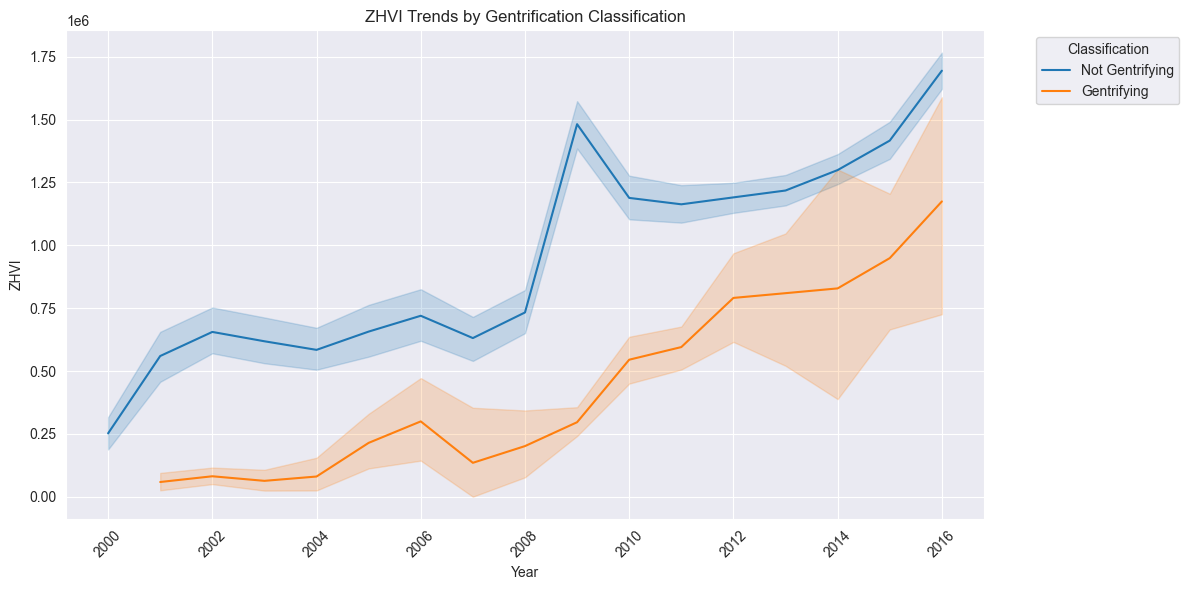

In [22]:
# Analyze how key variables like ZHVI, SEIFA, or eviction.rate change over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=data, x='Year', y='ZHVI', hue='Classification')
plt.title('ZHVI Trends by Gentrification Classification')
plt.ylabel('ZHVI')
plt.xticks(rotation=45)
plt.legend(title='Classification', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

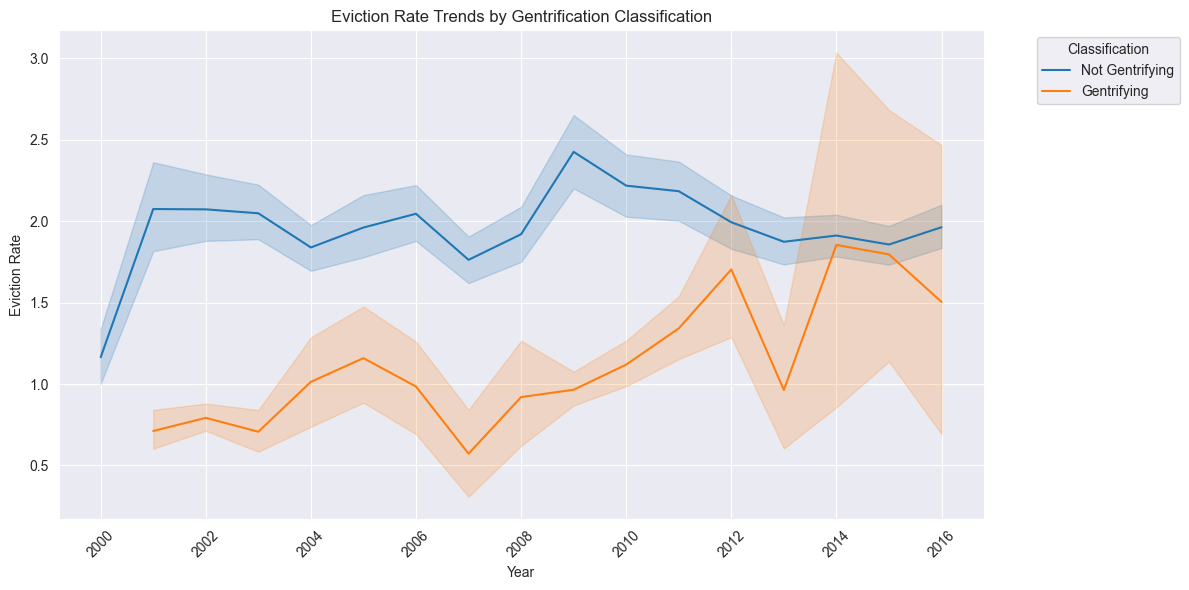

In [23]:
# Analyze how key variables like ZHVI, SEIFA, or eviction.rate change over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=data, x='Year', y='eviction.rate', hue='Classification')
plt.title('Eviction Rate Trends by Gentrification Classification')
plt.ylabel('Eviction Rate')
plt.xticks(rotation=45)
plt.legend(title='Classification', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

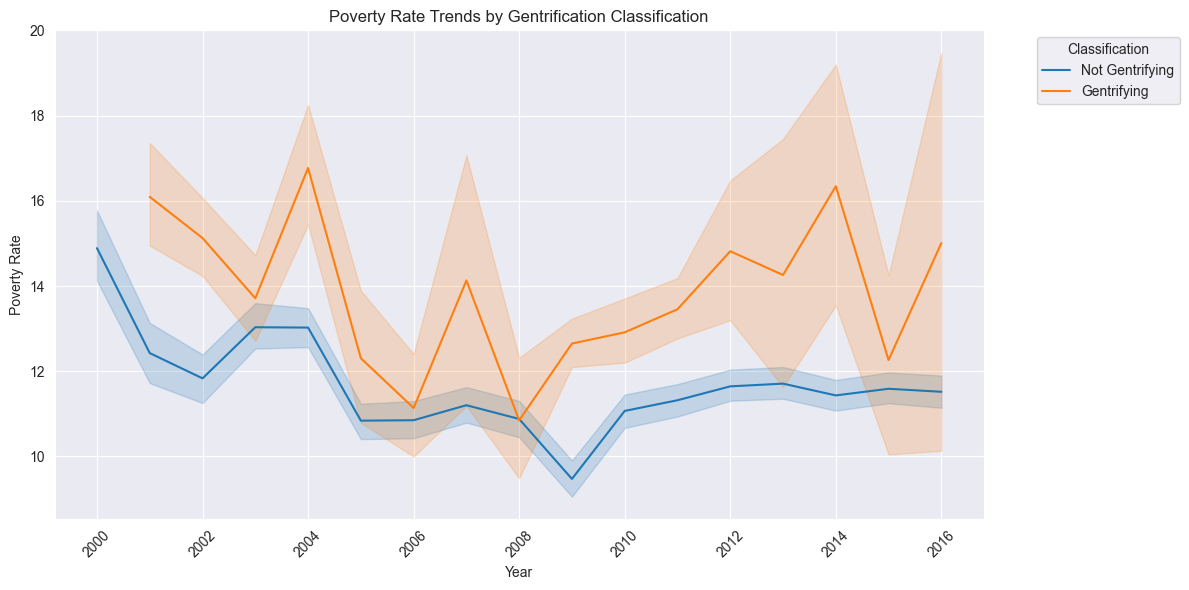

In [24]:
# Analyze how key variables like ZHVI, SEIFA, or eviction.rate change over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=data, x='Year', y='poverty.rate', hue='Classification')
plt.title('Poverty Rate Trends by Gentrification Classification')   
plt.ylabel('Poverty Rate')
plt.xticks(rotation=45)
plt.legend(title='Classification', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

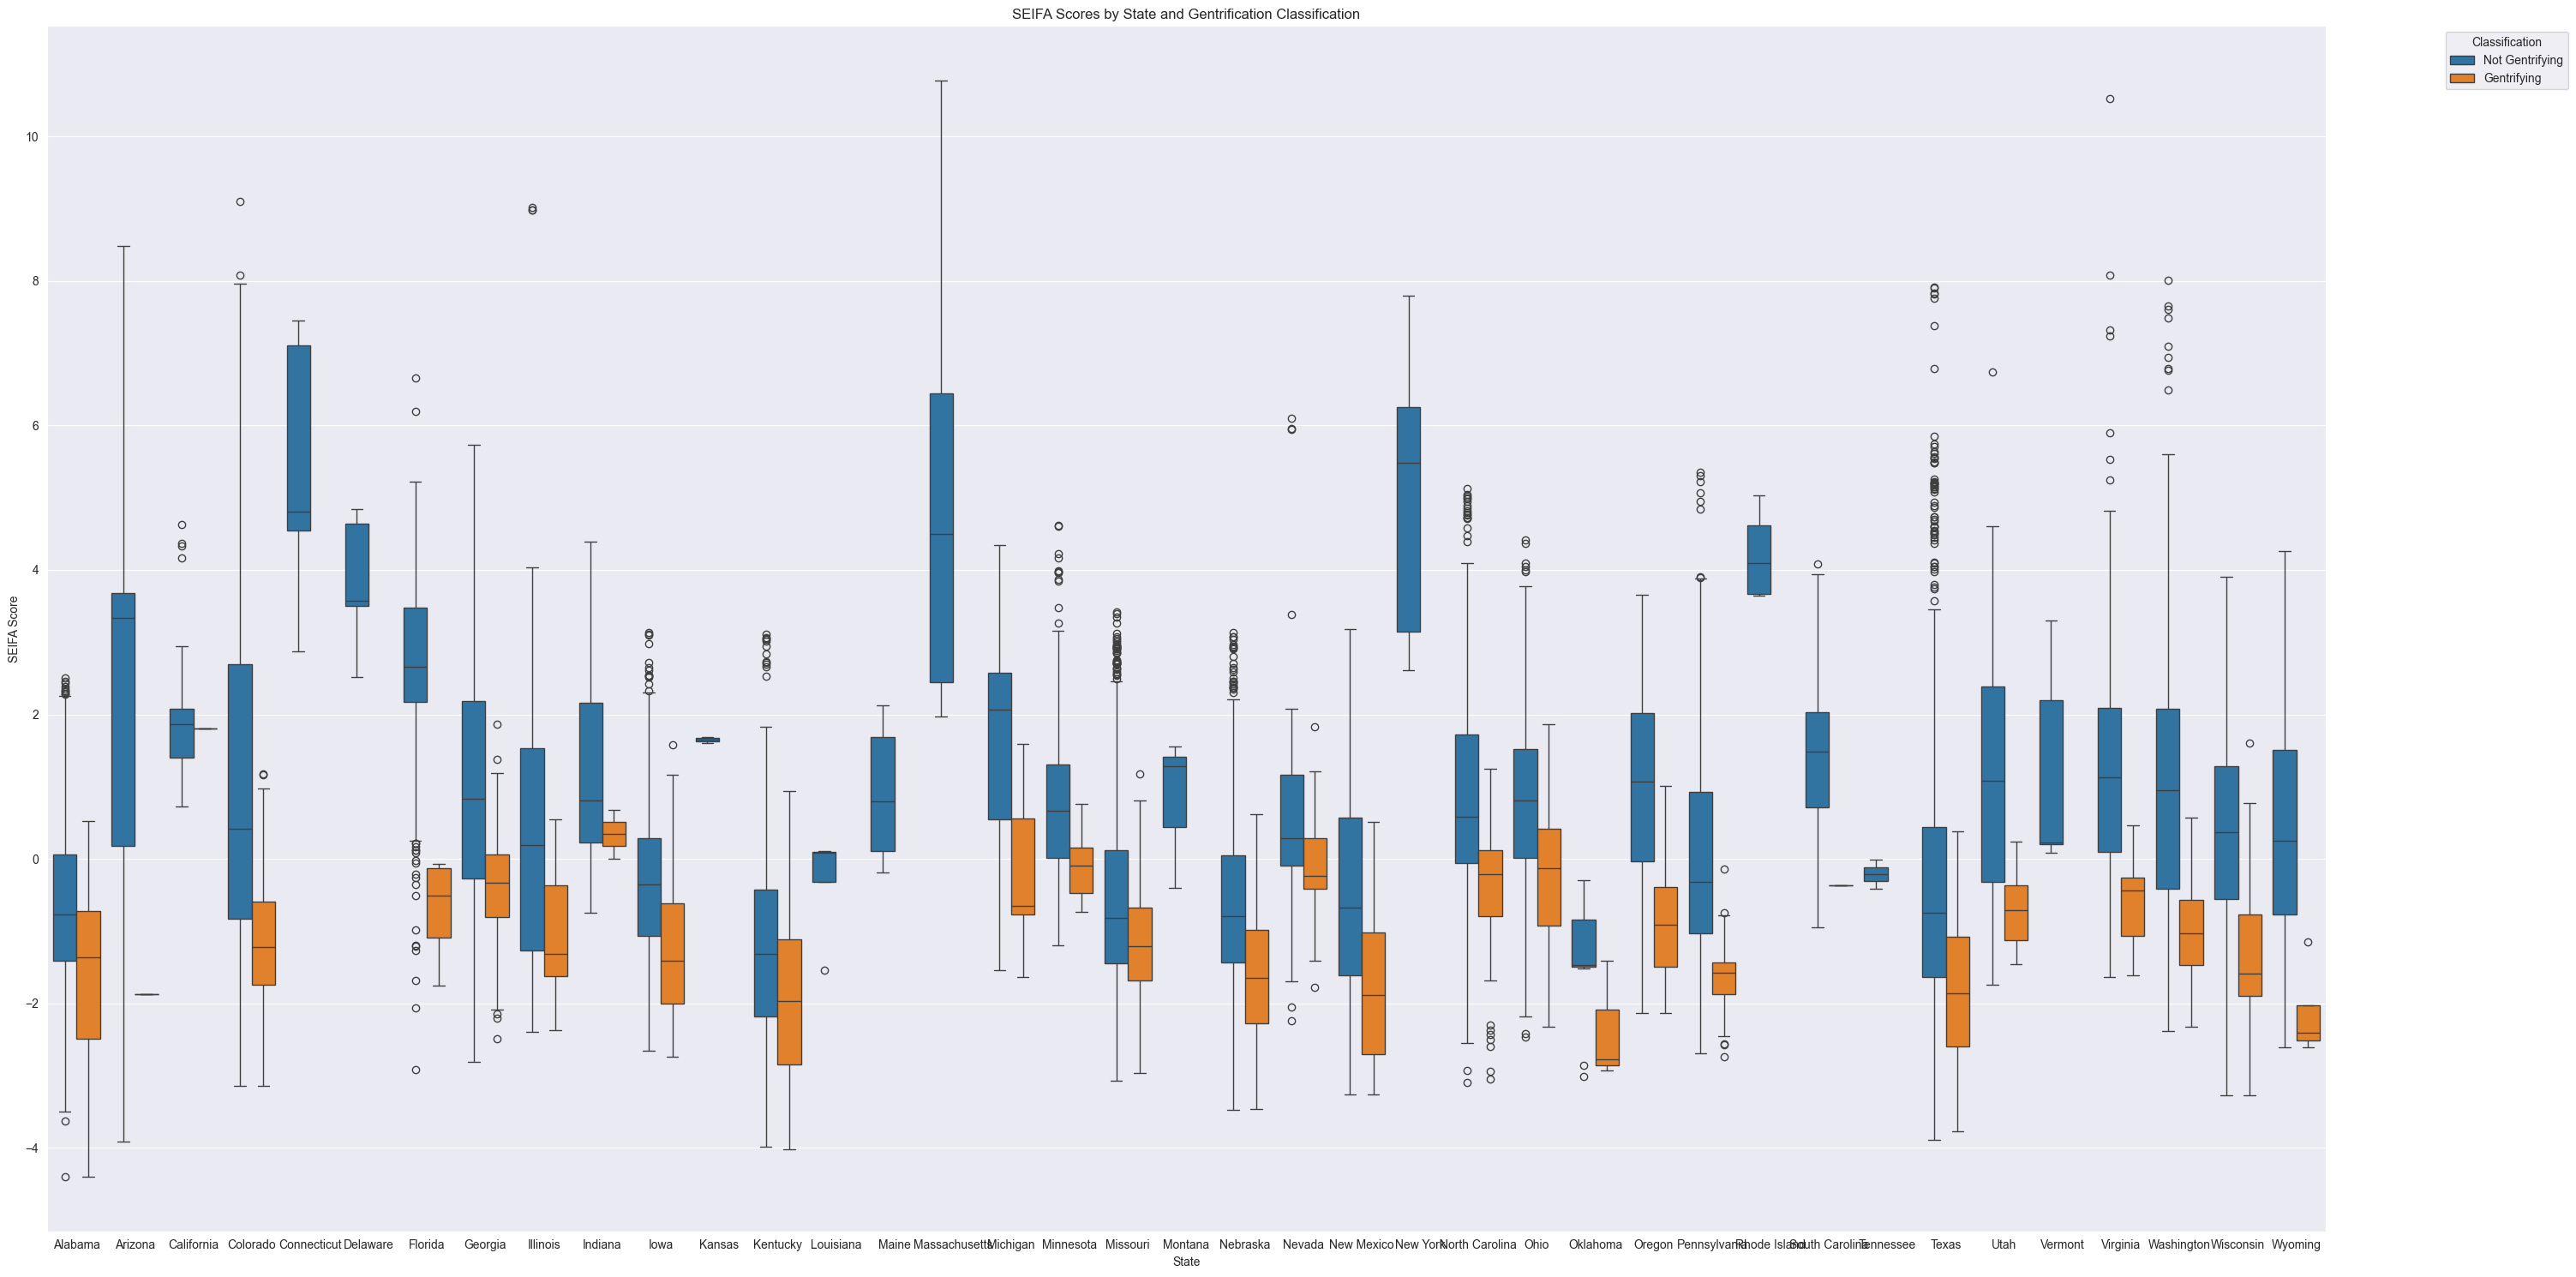

In [25]:
# Geospatial Trends: Plot geospatial data if longitude/latitude is available, or aggregate by regions/states.
plt.figure(figsize=(30,15))
sns.boxplot(data=data, x='State', y='SEIFA', hue='Classification')
plt.title('SEIFA Scores by State and Gentrification Classification')
plt.xlabel('State')
plt.ylabel('SEIFA Score')
plt.legend(title='Classification', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show() 

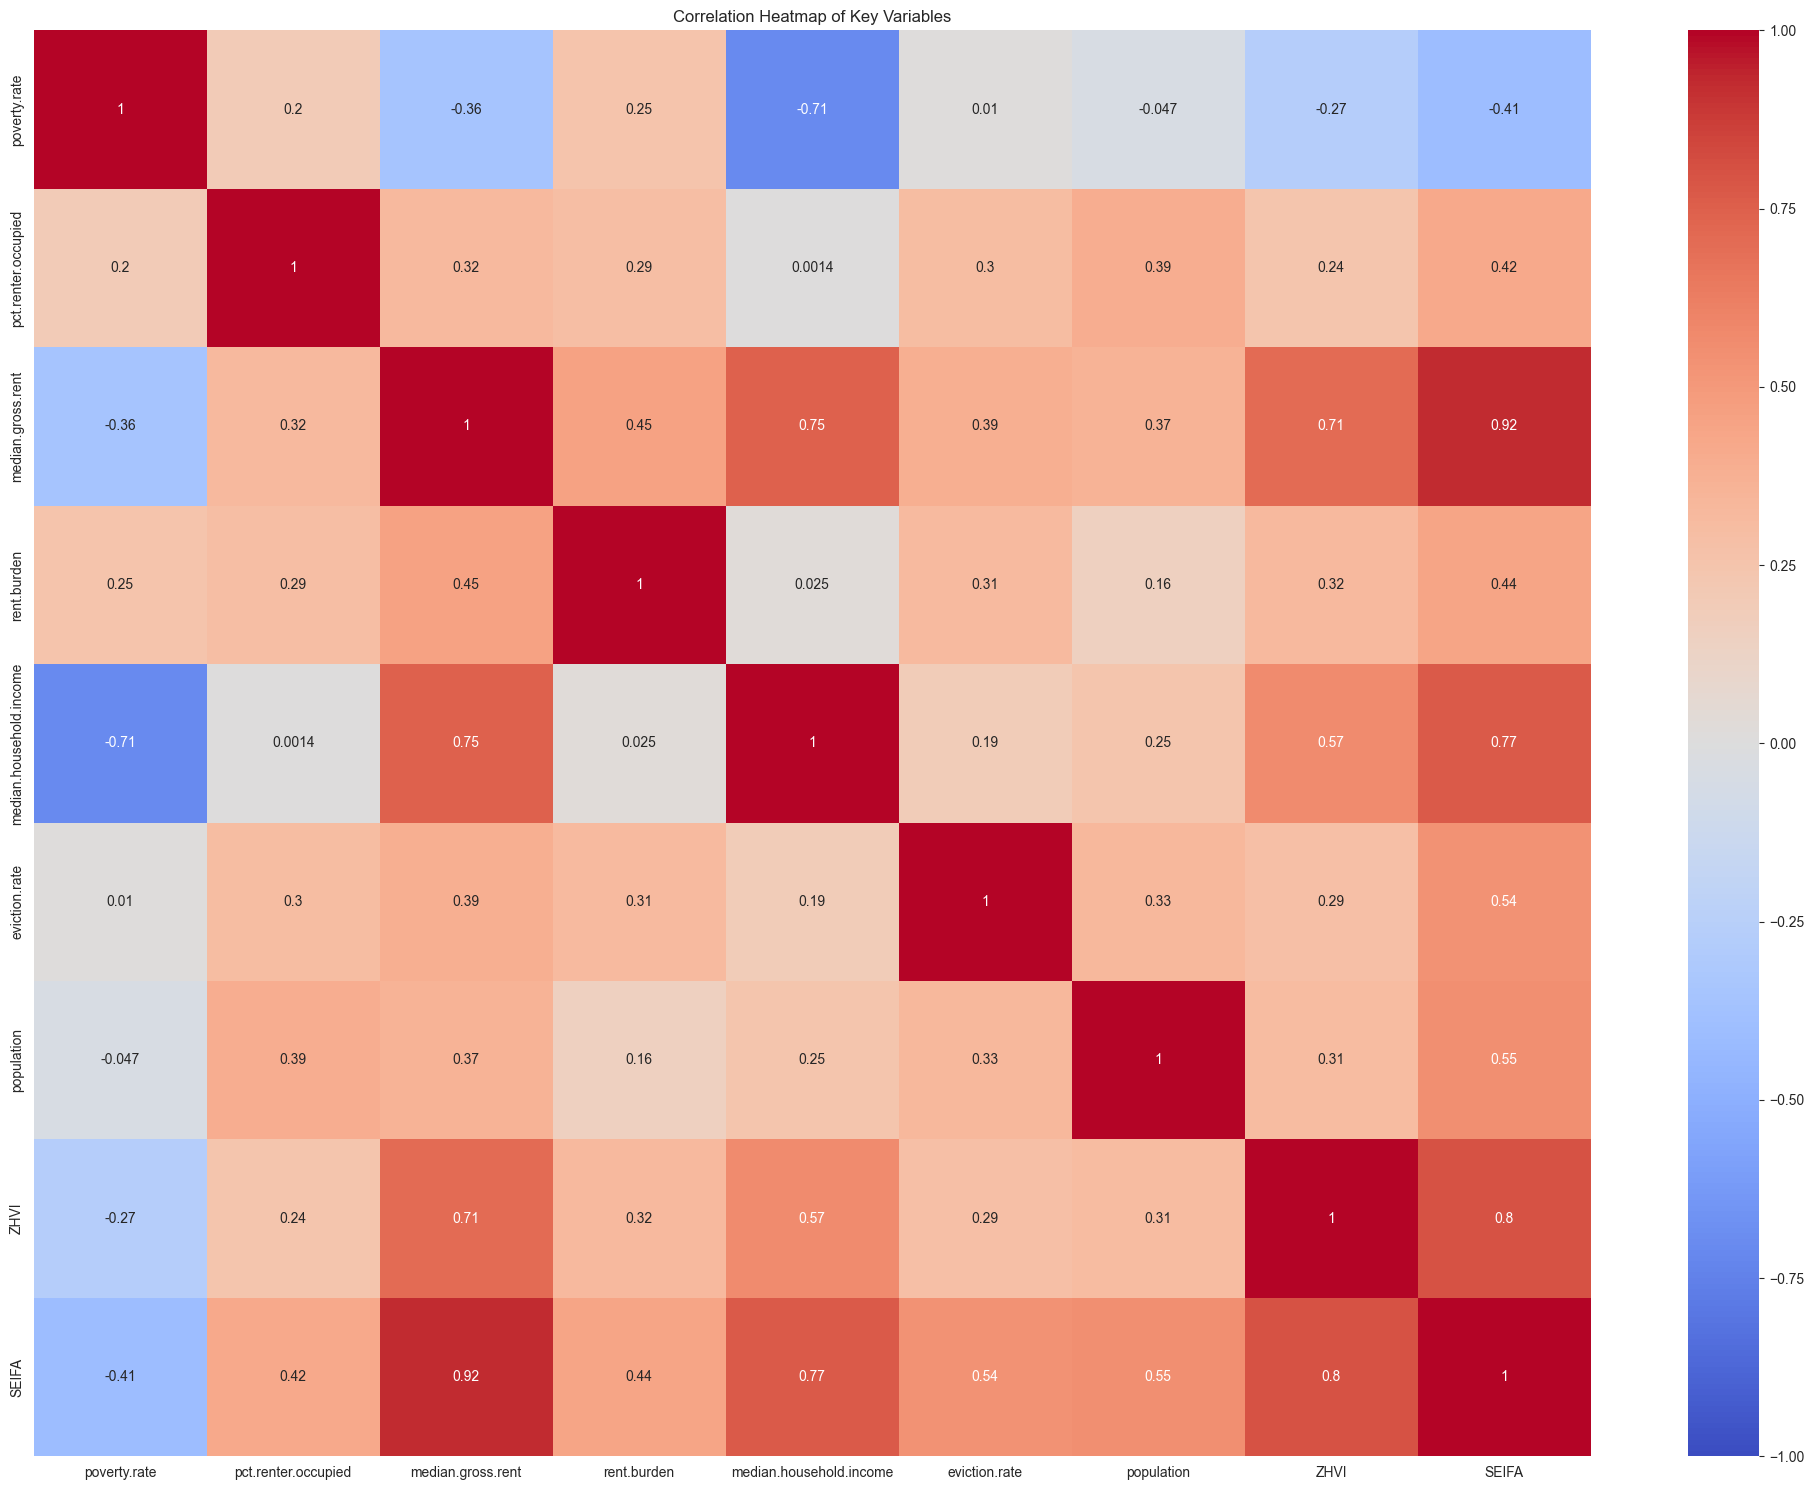

In [26]:
# Check correlations to identify multicollinearity and feature importance
correlation_matrix = data[['poverty.rate', 'pct.renter.occupied', 'median.gross.rent', 
                           'rent.burden', 'median.household.income', 'eviction.rate', 
                           'population', 'ZHVI', 'SEIFA']].corr()

plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Heatmap of Key Variables')
plt.tight_layout()
plt.show()


In [27]:
# Step 2: Feature Engineering

# Create new features or transform existing features to improve model performance
# Compute additional metrics such as: rent-to-income ratio, population density, etc.
data['rent_to_income_ratio'] = data['median.gross.rent'] / data['median.household.income']
data['population_density'] = data['population'] / data['ZHVI']

In [28]:
# Year-on-year change in ZHVI or SEIFA (growth rates).
data['ZHVI_growth_rate'] = data.groupby('RegionName')['ZHVI'].pct_change()

In [29]:
# Rolling averages for variables like eviction.rate.
data['eviction_rate_rolling_mean'] = data.groupby('GEOID')['eviction.rate'].rolling(window=3).mean().reset_index(0, drop=True)

In [30]:
# # Encode Categorical Variables: Convert categorical features (e.g., State, RegionType) into numeric values using one-hot encoding or label encoding.
# 
# # One-Hot Encoding for State
# data = pd.get_dummies(data, columns=['State'], drop_first=True)
# 
# # Label Encoding for RegionType
# data['RegionType'] = data['RegionType'].astype('category').cat.codes


In [31]:
print(data.head())

# Print which fetures are correlated with the target variable
# correlation_with_target = data.corr()['Classification'].sort_values(ascending=False)

   GEOID  Year      RegionName    State  population  poverty.rate  \
0   1001  2008  Autauga County  Alabama     49584.0          7.52   
1   1001  2009  Autauga County  Alabama     49584.0          7.52   
2   1001  2011  Autauga County  Alabama     55221.0          9.28   
3   1001  2012  Autauga County  Alabama     55221.0          9.28   
4   1001  2013  Autauga County  Alabama     55221.0          9.28   

   renter.occupied.households  pct.renter.occupied  median.gross.rent  \
0                        4593                22.45              779.0   
1                        4783                22.45              779.0   
2                        5040                26.08              883.0   
3                        5107                26.08              883.0   
4                        5174                26.08              883.0   

   median.household.income  ...          ZHVI     SEIFA   Rank  Rank_Change  \
0                  51463.0  ...  1.957993e+06  1.454775  111.0     

In [32]:
# print columns inside the data

print(data.columns)


Index(['GEOID', 'Year', 'RegionName', 'State', 'population', 'poverty.rate',
       'renter.occupied.households', 'pct.renter.occupied',
       'median.gross.rent', 'median.household.income', 'median.property.value',
       'rent.burden', 'pct.white', 'pct.af.am', 'pct.hispanic', 'pct.am.ind',
       'pct.asian', 'pct.nh.pi', 'pct.multiple', 'pct.other',
       'eviction.filings', 'evictions', 'eviction.rate',
       'eviction.filing.rate', 'low.flag', 'imputed', 'subbed', 'RegionID',
       'SizeRank', 'RegionType', 'Metro', 'StateCodeFIPS', 'MunicipalCodeFIPS',
       'ZHVI', 'SEIFA', 'Rank', 'Rank_Change', 'Rank_Change_SD',
       'Classification', 'rent_to_income_ratio', 'population_density',
       'ZHVI_growth_rate', 'eviction_rate_rolling_mean'],
      dtype='object')


In [33]:
import pandas as pd

# Describe the data for numerical columns only
numerical_data = data.select_dtypes(include=['int64', 'float64'])

# Look for columns with high variance or large ranges
wide_range_columns = [col for col in numerical_data.columns if numerical_data[col].max() - numerical_data[col].min() > 1000]
print("Columns with wide ranges:", wide_range_columns)



Columns with wide ranges: ['GEOID', 'population', 'renter.occupied.households', 'median.gross.rent', 'median.household.income', 'median.property.value', 'eviction.filings', 'evictions', 'RegionID', 'SizeRank', 'ZHVI', 'population_density', 'ZHVI_growth_rate']


In [34]:
# Ensure numeric features (e.g., poverty.rate, median.gross.rent) are scaled for consistent model performance.
scaler = StandardScaler()

data_scaled = scaler.fit_transform(data[['population', 'poverty.rate',
       'renter.occupied.households', 'pct.renter.occupied',
       'median.gross.rent', 'median.household.income', 'median.property.value',
       'rent.burden', 'pct.white', 'pct.af.am', 'pct.hispanic', 'pct.am.ind',
       'pct.asian', 'pct.nh.pi', 'pct.multiple', 'pct.other',
       'eviction.filings', 'evictions', 'eviction.rate',
       'eviction.filing.rate',
       'ZHVI']])

# data_scaled = scaler.fit_transform(data[['population', 'renter.occupied.households', 'median.gross.rent', 'median.household.income', 'median.property.value', 'eviction.filings', 'evictions', 'SizeRank', 'ZHVI']])

In [35]:
# total number of observations
print(data.shape[0])

#no of observations that has NaN values- only for Classification column

# Check for NaN values in the 'Classification' column
nan_count = data['Classification'].isna().sum()

# Print the result
print(f"Number of observations with NaN in 'Classification' column: {nan_count}")


10834
Number of observations with NaN in 'Classification' column: 0


In [36]:
# Perform PCA to reduce dimensionality and capture key components of the data.
pca = PCA(n_components=0.95)
data_pca = pca.fit_transform(data_scaled) 


# Number of components to explain 95% of the variance
print("Number of components:", pca.n_components_)

# Create the DataFrame with PCA components and ensure 'Classification' is aligned correctly
data_preprocessed = pd.DataFrame(data_pca, columns=[f'PCA_{i+1}' for i in range(data_pca.shape[1])])

# Ensure that the 'Classification' column is properly added back to the new DataFrame
data_preprocessed['Classification'] = data['Classification'].values

# Check the first few rows to ensure the 'Classification' column is properly added
print(data_preprocessed.head())

# Total number of observations after PCA and adding 'Classification' column
print(data_preprocessed.shape[0])

# Check for NaN values in the 'Classification' column again
nan_count = data_preprocessed['Classification'].isna().sum()
print(f"Number of observations with NaN in 'Classification' column: {nan_count}")


Number of components: 13
      PCA_1     PCA_2     PCA_3     PCA_4     PCA_5     PCA_6     PCA_7  \
0  0.546230 -1.347996  0.754129 -0.385103  0.816220  0.069399 -0.778815   
1  0.427421 -1.373170  0.676090 -0.199311  0.759423  0.004093 -0.912103   
2  1.182679 -1.248584  1.531357  0.023984  0.227375 -0.378112 -1.165689   
3  1.329780 -1.197194  1.619555 -0.222873  0.300643 -0.291185 -0.979275   
4  1.386728 -1.192537  1.653685 -0.299144  0.323844 -0.264597 -0.929600   

      PCA_8     PCA_9    PCA_10    PCA_11    PCA_12    PCA_13   Classification  
0 -0.367581 -0.625863  0.244178 -0.591367 -0.422754 -0.230693  Not Gentrifying  
1 -0.374339 -0.660732  0.318445 -0.638488 -0.441536 -0.292527  Not Gentrifying  
2 -0.187921 -0.281287  0.202361 -0.675232  0.082505 -0.792969  Not Gentrifying  
3 -0.176340 -0.236354  0.117269 -0.624719  0.121563 -0.737802  Not Gentrifying  
4 -0.175109 -0.221311  0.080281 -0.601343  0.122907 -0.701825  Not Gentrifying  
10834
Number of observations with NaN 

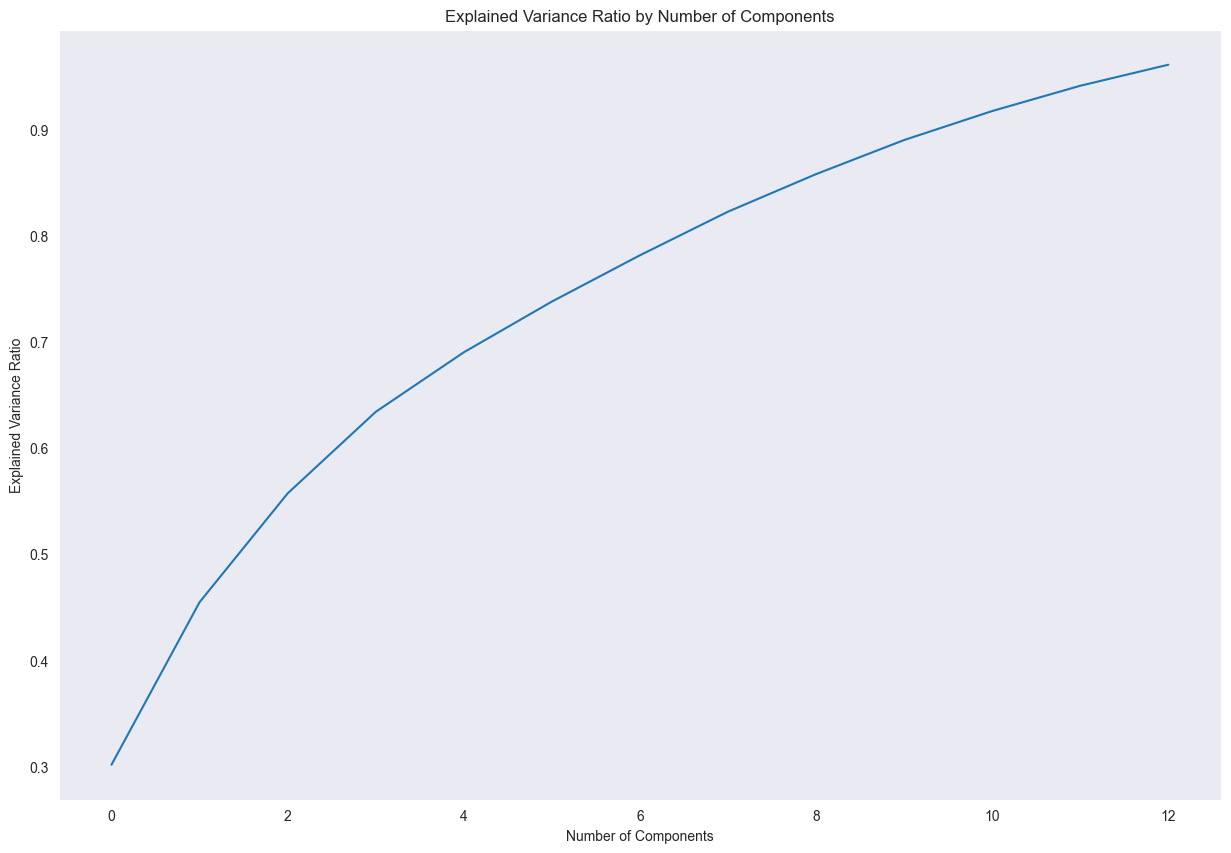

In [37]:
# Visualize the explained variance ratio of PCA components
plt.figure(figsize=(15, 10))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio by Number of Components')
plt.grid()
plt.show()


In [38]:
# Handle Class Imbalance: If Classification is imbalanced, use techniques like oversampling (SMOTE) or assign class weights in models.
data_preprocessed['Classification'].value_counts()


Classification
Not Gentrifying    9255
Gentrifying        1579
Name: count, dtype: int64

In [39]:
data_preprocessed.head()

PCA_1     PCA_2     PCA_3     PCA_4     PCA_5     PCA_6     PCA_7  \
0  0.546230 -1.347996  0.754129 -0.385103  0.816220  0.069399 -0.778815   
1  0.427421 -1.373170  0.676090 -0.199311  0.759423  0.004093 -0.912103   
2  1.182679 -1.248584  1.531357  0.023984  0.227375 -0.378112 -1.165689   
3  1.329780 -1.197194  1.619555 -0.222873  0.300643 -0.291185 -0.979275   
4  1.386728 -1.192537  1.653685 -0.299144  0.323844 -0.264597 -0.929600   

      PCA_8     PCA_9    PCA_10    PCA_11    PCA_12    PCA_13   Classification  
0 -0.367581 -0.625863  0.244178 -0.591367 -0.422754 -0.230693  Not Gentrifying  
1 -0.374339 -0.660732  0.318445 -0.638488 -0.441536 -0.292527  Not Gentrifying  
2 -0.187921 -0.281287  0.202361 -0.675232  0.082505 -0.792969  Not Gentrifying  
3 -0.176340 -0.236354  0.117269 -0.624719  0.121563 -0.737802  Not Gentrifying  
4 -0.175109 -0.221311  0.080281 -0.601343  0.122907 -0.701825  Not Gentrifying

In [40]:
data_preprocessed['Classification'] = data_preprocessed['Classification'].map({'Not Gentrifying': 0, 'Gentrifying': 1})


In [41]:
data_preprocessed.head()

PCA_1     PCA_2     PCA_3     PCA_4     PCA_5     PCA_6     PCA_7  \
0  0.546230 -1.347996  0.754129 -0.385103  0.816220  0.069399 -0.778815   
1  0.427421 -1.373170  0.676090 -0.199311  0.759423  0.004093 -0.912103   
2  1.182679 -1.248584  1.531357  0.023984  0.227375 -0.378112 -1.165689   
3  1.329780 -1.197194  1.619555 -0.222873  0.300643 -0.291185 -0.979275   
4  1.386728 -1.192537  1.653685 -0.299144  0.323844 -0.264597 -0.929600   

      PCA_8     PCA_9    PCA_10    PCA_11    PCA_12    PCA_13  Classification  
0 -0.367581 -0.625863  0.244178 -0.591367 -0.422754 -0.230693               0  
1 -0.374339 -0.660732  0.318445 -0.638488 -0.441536 -0.292527               0  
2 -0.187921 -0.281287  0.202361 -0.675232  0.082505 -0.792969               0  
3 -0.176340 -0.236354  0.117269 -0.624719  0.121563 -0.737802               0  
4 -0.175109 -0.221311  0.080281 -0.601343  0.122907 -0.701825               0

In [42]:
#Pipeline for Hyperparameter tuning
# model_names = ['Logistic Regression', 'Random Forest', 'SVM', 'Neural Network', 'K-Nearest Neighbors', 'Decision Tree', 'Naive Bayes', 'XG Boost', 'Light Gradient Boosting Machine']

X = data_preprocessed.drop('Classification', axis=1)
y = data_preprocessed['Classification']

In [43]:

# Define models and their respective parameter grids
param_grids = {
    'Logistic Regression': {
        'classifier__C': [0.1, 1, 10],
        'classifier__penalty': ['l2'],
        'classifier__solver': ['lbfgs'],
    },
    'Random Forest': {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_depth': [None, 10, 20],
        'classifier__min_samples_split': [2, 5, 10],
    },
    # 'SVM': {
    #     'classifier__C': [0.1, 1, 10],
    #     'classifier__kernel': ['linear', 'rbf'],
    # },
    'Neural Network': {
        'classifier__hidden_layer_sizes': [(50,), (100,), (50, 50)],
        'classifier__activation': ['relu', 'tanh'],
        'classifier__solver': ['adam'],
    },
    'K-Nearest Neighbors': {
        'classifier__n_neighbors': [3, 5, 7],
        'classifier__weights': ['uniform', 'distance'],
    },
    'Decision Tree': {
        'classifier__max_depth': [None, 10, 20],
        'classifier__min_samples_split': [2, 5, 10],
    },
    'Naive Bayes': {},  # No hyperparameters to tune for GaussianNB
    'XG Boost': {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__learning_rate': [0.01, 0.1, 0.2],
        'classifier__max_depth': [3, 5, 7],
    },
    'Light Gradient Boosting Machine': {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__learning_rate': [0.01, 0.1, 0.2],
        'classifier__num_leaves': [31, 50, 100],
    },
}


In [44]:

# Initialize classifiers
classifiers = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    # 'SVM': SVC(),
    'Neural Network': MLPClassifier(max_iter=1000),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Naive Bayes': GaussianNB(),
    'XG Boost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'Light Gradient Boosting Machine': LGBMClassifier(),
}



In [45]:
# Dictionary to store best parameters
best_params = {}

# Perform grid search for each classifier
for name, classifier in classifiers.items():
    print(f"Running GridSearchCV for {name}...")
    
    # Create a pipeline with a scaler and the classifier
    pipeline = Pipeline([
        ('classifier', classifier)
    ])

    # Get the parameter grid for the classifier
    param_grid = param_grids.get(name, {})

    # Initialize GridSearchCV
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    
    # Fit the grid search
    grid_search.fit(X, y)

    # Store the best parameters
    best_params[name] = grid_search.best_params_

# Print the best parameters
for model, params in best_params.items():
    print(f"Best parameters for {model}: {params}")


Running GridSearchCV for Logistic Regression...
Running GridSearchCV for Random Forest...
Running GridSearchCV for Neural Network...


/Users/kunal/Desktop/Fall 2024/3rd Semester/Urban/final/venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Running GridSearchCV for K-Nearest Neighbors...
Running GridSearchCV for Decision Tree...
Running GridSearchCV for Naive Bayes...
Running GridSearchCV for XG Boost...


/Users/kunal/Desktop/Fall 2024/3rd Semester/Urban/final/venv/lib/python3.11/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The XGBClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/Users/kunal/Desktop/Fall 2024/3rd Semester/Urban/final/venv/lib/python3.11/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The XGBClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.R

Running GridSearchCV for Light Gradient Boosting Machine...


/Users/kunal/Desktop/Fall 2024/3rd Semester/Urban/final/venv/lib/python3.11/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/Users/kunal/Desktop/Fall 2024/3rd Semester/Urban/final/venv/lib/python3.11/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base

[LightGBM] [Info] Number of positive: 1579, number of negative: 9255
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000413 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 10834, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.145745 -> initscore=-1.768372
[LightGBM] [Info] Start training from score -1.768372
Best parameters for Logistic Regression: {'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}
Best parameters for Random Forest: {'classifier__max_depth': 10, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 50}
Best parameters for Neural Network: {'classifier__activation': 'relu', 'classifier__hidden_layer_sizes': (50,), 'classifier__solver': 'adam'}
Best parameters for K-Nearest Neighbors: {'classifier__n_neighbors': 7, 'classifier__weights': 'uniform'}
Be

Evaluating Logistic Regression with cross-validation...


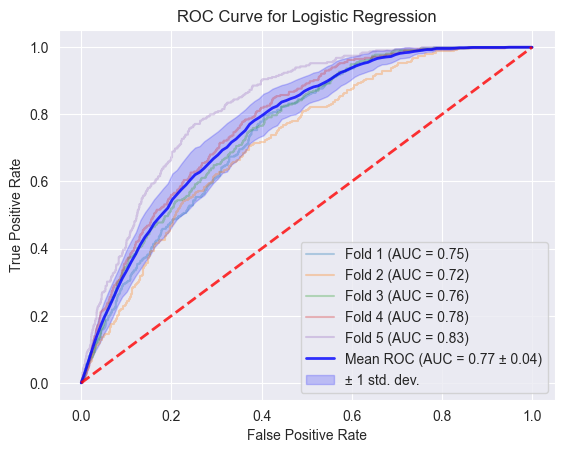

Evaluating Random Forest with cross-validation...


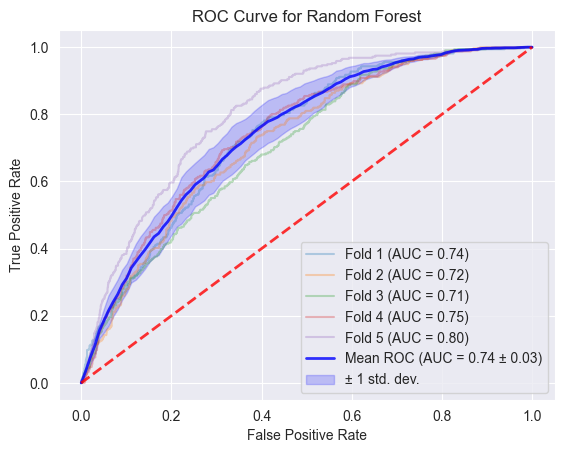

Evaluating Neural Network with cross-validation...


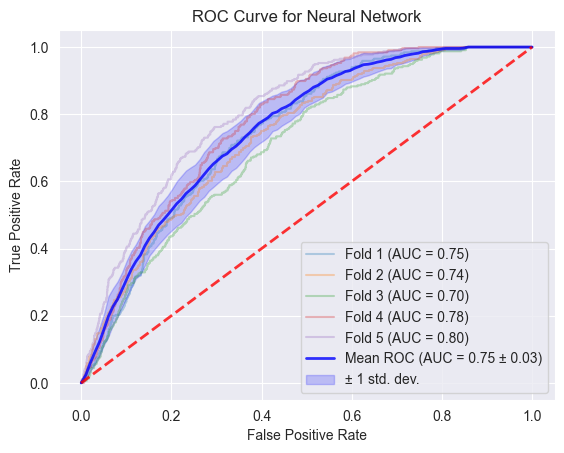

Evaluating K-Nearest Neighbors with cross-validation...


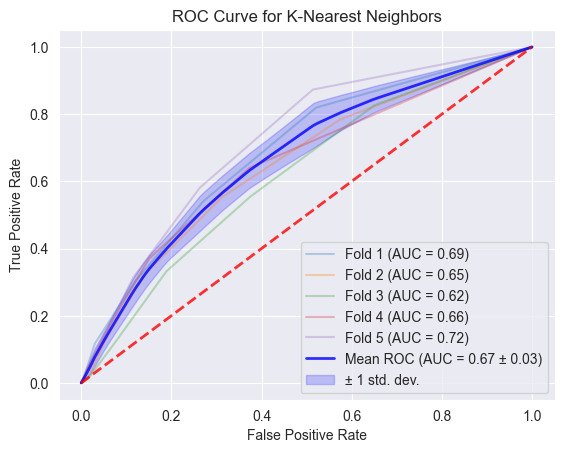

Evaluating Decision Tree with cross-validation...


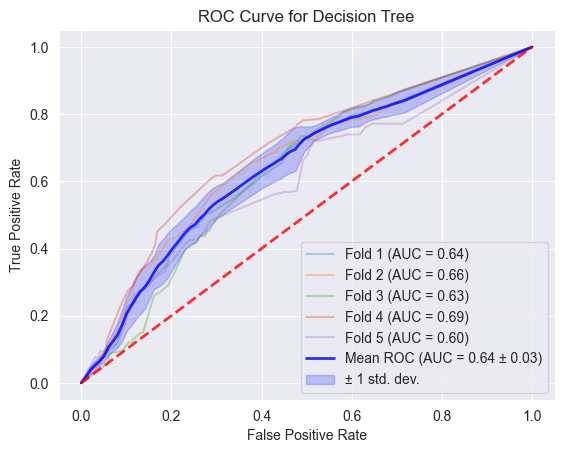

Evaluating Naive Bayes with cross-validation...


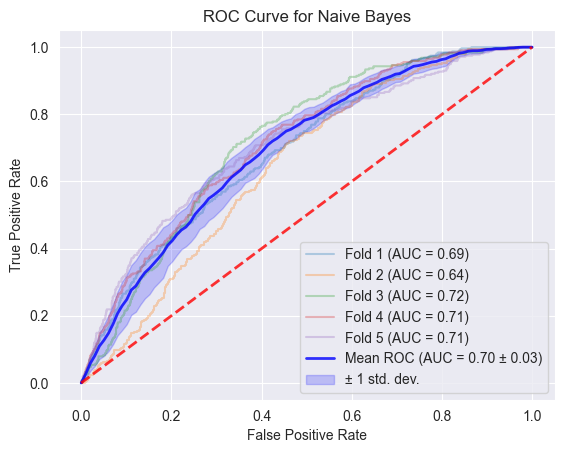

Evaluating XG Boost with cross-validation...


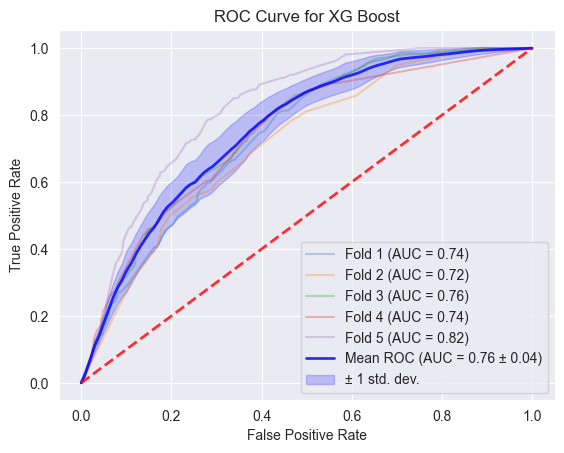

Evaluating Light Gradient Boosting Machine with cross-validation...
[LightGBM] [Info] Number of positive: 1263, number of negative: 7404
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000336 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 8667, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.145725 -> initscore=-1.768531
[LightGBM] [Info] Start training from score -1.768531
[LightGBM] [Info] Number of positive: 1263, number of negative: 7404
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000351 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 8667, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.145725 -> initscore=-1.768531
[Lig

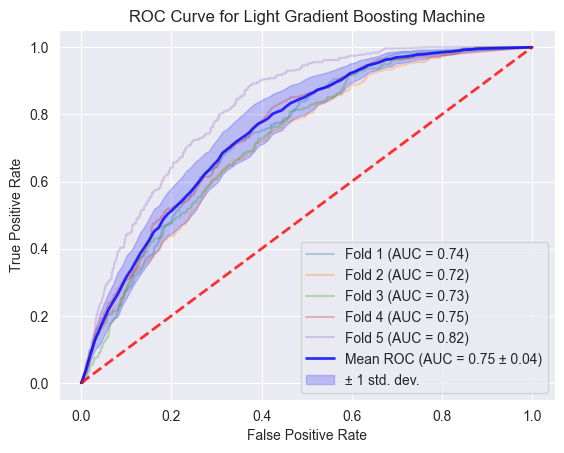

Metrics for Logistic Regression: {'accuracy': np.float64(0.8513018453159349), 'precision': np.float64(0.7873564893419356), 'recall': np.float64(0.8513018453159349), 'f1_score': np.float64(0.7930345642398925)}
Metrics for Random Forest: {'accuracy': np.float64(0.8523169885221152), 'precision': np.float64(0.7602621400649474), 'recall': np.float64(0.8523169885221152), 'f1_score': np.float64(0.7885232752964286)}
Metrics for Neural Network: {'accuracy': np.float64(0.8447485385798308), 'precision': np.float64(0.7844576785113226), 'recall': np.float64(0.8447485385798308), 'f1_score': np.float64(0.7955716634271913)}
Metrics for K-Nearest Neighbors: {'accuracy': np.float64(0.8326568978733722), 'precision': np.float64(0.7823096844014849), 'recall': np.float64(0.8326568978733722), 'f1_score': np.float64(0.7969532952056405)}
Metrics for Decision Tree: {'accuracy': np.float64(0.8094890153272818), 'precision': np.float64(0.7653559907902828), 'recall': np.float64(0.8094890153272818), 'f1_score': np.f

In [46]:
metrics = {}
X = np.array(X)  
y = np.array(y)  
cv = StratifiedKFold(n_splits=5)
for name, classifier in classifiers.items():
    print(f"Evaluating {name} with cross-validation...")
    classifier.set_params(**{key.split('__')[1]: value for key, value in best_params[name].items()})

    # Arrays to store metrics for each fold
    accuracies, precisions, recalls, f1_scores = [], [], [], []
    tprs, aucs = [], []
    mean_fpr = np.linspace(0, 1, 100)

    plt.figure()
    for fold_idx, (train_idx, test_idx) in enumerate(cv.split(X, y), start=1):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Fit model
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        y_proba = classifier.predict_proba(X_test) if hasattr(classifier, 'predict_proba') else None

        # Compute metrics
        accuracies.append(accuracy_score(y_test, y_pred))
        precisions.append(precision_score(y_test, y_pred, average='weighted'))
        recalls.append(recall_score(y_test, y_pred, average='weighted'))
        f1_scores.append(f1_score(y_test, y_pred, average='weighted'))

        # Compute ROC curve
        if y_proba is not None:
            if len(np.unique(y)) > 2:  # Multi-class case
                y_test_bin = label_binarize(y_test, classes=np.unique(y))
                fpr, tpr, _ = roc_curve(y_test_bin[:, 1], y_proba[:, 1])
            else:  # Binary classification
                fpr, tpr, _ = roc_curve(y_test, y_proba[:, 1])

            tprs.append(np.interp(mean_fpr, fpr, tpr))
            tprs[-1][0] = 0.0
            roc_auc = auc(fpr, tpr)
            aucs.append(roc_auc)
            plt.plot(fpr, tpr, alpha=0.3, label=f'Fold {fold_idx} (AUC = {roc_auc:.2f})')

    # Plot mean ROC curve
    if tprs:
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)
        plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})', lw=2, alpha=0.8)
        plt.fill_between(mean_fpr, mean_tpr - np.std(tprs, axis=0), mean_tpr + np.std(tprs, axis=0), color='b', alpha=0.2, label='± 1 std. dev.')

    plt.plot([0, 1], [0, 1], linestyle='--', color='r', lw=2, alpha=0.8)
    plt.title(f'ROC Curve for {name}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

    # Store average metrics
    metrics[name] = {
        'accuracy': np.mean(accuracies),
        'precision': np.mean(precisions),
        'recall': np.mean(recalls),
        'f1_score': np.mean(f1_scores)
    }

# Print metrics
for model, metric in metrics.items():
    print(f"Metrics for {model}: {metric}")


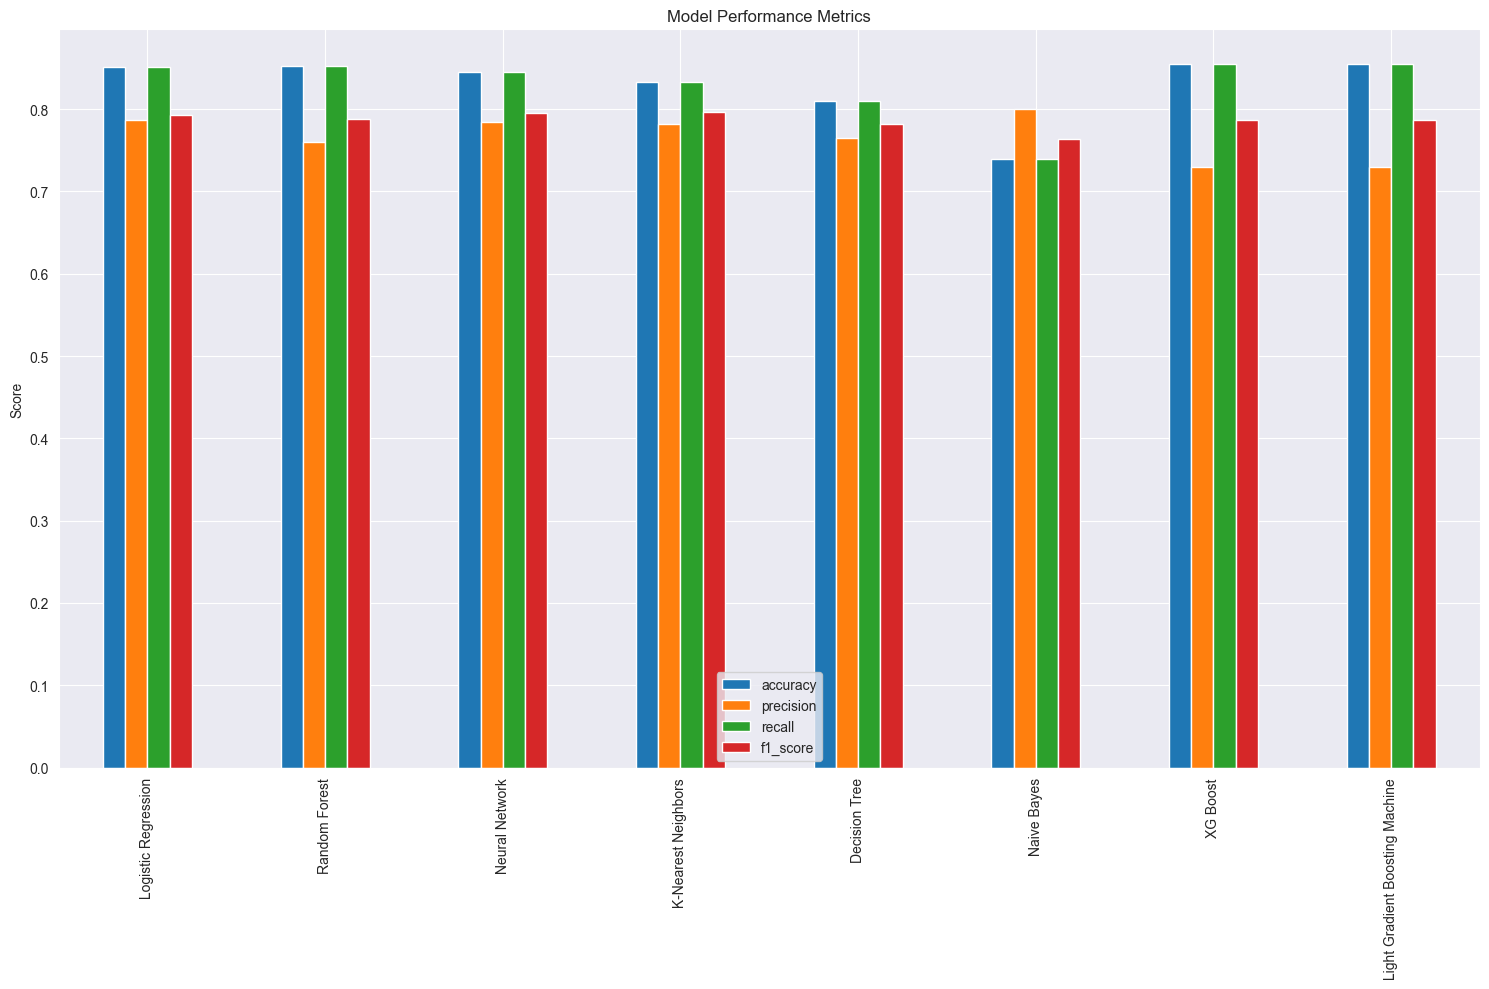

In [47]:
# Visualize the metrics
metrics_df = pd.DataFrame(metrics).T
metrics_df.plot(kind='bar', figsize=(15, 10))
plt.title('Model Performance Metrics')
plt.ylabel('Score')
plt.tight_layout()
plt.show()


In [48]:
# print the metric in tabular format
metrics_df

accuracy  precision    recall  f1_score
Logistic Regression              0.851302   0.787356  0.851302  0.793035
Random Forest                    0.852317   0.760262  0.852317  0.788523
Neural Network                   0.844749   0.784458  0.844749  0.795572
K-Nearest Neighbors              0.832657   0.782310  0.832657  0.796953
Decision Tree                    0.809489   0.765356  0.809489  0.782501
Naive Bayes                      0.739157   0.800531  0.739157  0.763711
XG Boost                         0.854255   0.729752  0.854255  0.787111
Light Gradient Boosting Machine  0.854255   0.729752  0.854255  0.787111

In [49]:
# Drop Naive Bayes from the classifiers


In [50]:
# Explainability and Visualization

# Use SHAP values to explain model predictions and feature importance.

# Load Preprocessed Data

# PCA-transformed dataset
X = data_preprocessed.drop(columns=['Classification']).values
y = data_preprocessed['Classification'].values

# Pick one of your trained models (e.g., Random Forest) to explain its predictions.
model = classifiers['Logistic Regression']  # Replace with the desired model

# SHAP will interpret the model's predictions by assigning importance scores to features.
# Initialize SHAP Explainer
explainer = shap.Explainer(model, X)
shap_values = explainer(X)


In [51]:
print("Shape of shap_values:", shap_values.shape)
print("Shape of X:", X.shape)
print("Number of feature names:", len([f'PCA_{i+1}' for i in range(X.shape[1])]))


Shape of shap_values: (10834, 13)
Shape of X: (10834, 13)
Number of feature names: 13


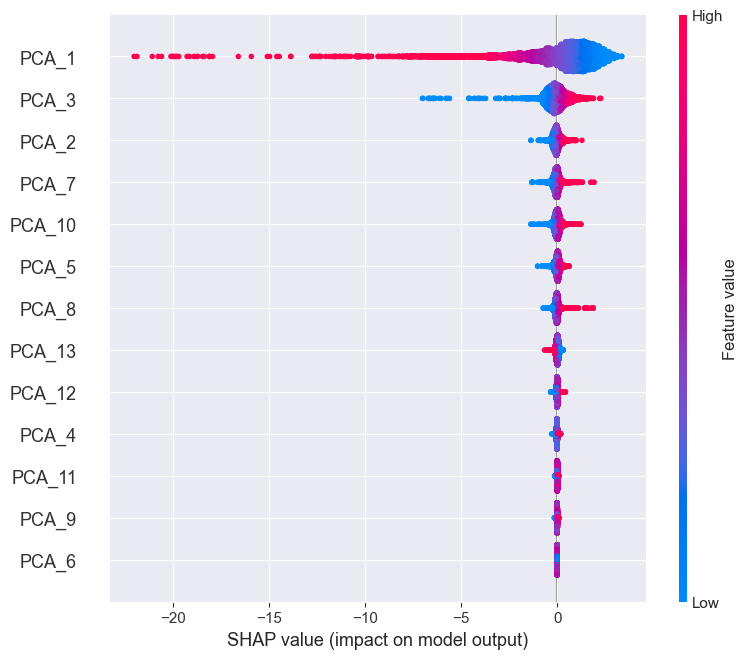

In [52]:
# Visualize Feature Importance

# Summary Plot: Displays the overall importance of features in the dataset.
shap.summary_plot(shap_values, X, feature_names=[f'PCA_{i+1}' for i in range(X.shape[1])])



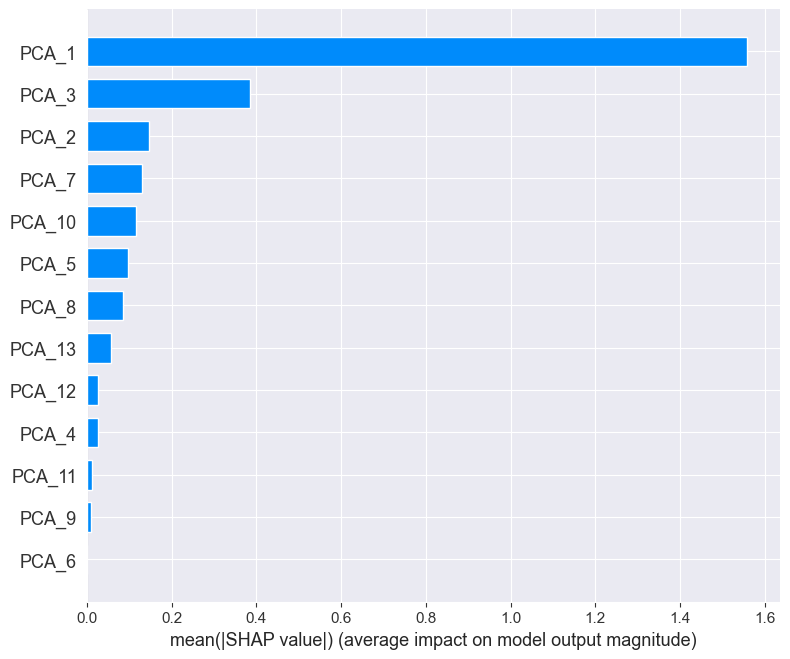

In [53]:
# Bar Plot: Highlights the top features in descending order of importance.

shap.summary_plot(shap_values, X, plot_type='bar', feature_names=[f'PCA_{i+1}' for i in range(X.shape[1])])


In [54]:
# # Dependence Plot: Shows how a specific feature influences predictions.
# 
# shap.dependence_plot(0, shap_values, X, feature_names=[f'PCA_{i+1}' for i in range(X.shape[1])])

In [55]:
# Retrieve PCA components and their contribution to original features
pca_components = pca.components_
original_features = ['population', 'poverty.rate',
       'renter.occupied.households', 'pct.renter.occupied',
       'median.gross.rent', 'median.household.income', 'median.property.value',
       'rent.burden', 'pct.white', 'pct.af.am', 'pct.hispanic', 'pct.am.ind',
       'pct.asian', 'pct.nh.pi', 'pct.multiple', 'pct.other',
       'eviction.filings', 'evictions', 'eviction.rate',
       'eviction.filing.rate',
       'ZHVI']

# Map top PCA components to original features
for i, component in enumerate(pca_components[:13]):  # Top 13 PCA components
    print(f"PCA_{i+1} Contributions:")
    for j, feature in enumerate(original_features):
        print(f"{feature}: {component[j]:.4f}")
    print('\n')


PCA_1 Contributions:
population: 0.3192
poverty.rate: -0.0427
renter.occupied.households: 0.3149
pct.renter.occupied: 0.2296
median.gross.rent: 0.2916
median.household.income: 0.1910
median.property.value: 0.2411
rent.burden: 0.1662
pct.white: -0.1547
pct.af.am: 0.1191
pct.hispanic: 0.0619
pct.am.ind: -0.0090
pct.asian: 0.2798
pct.nh.pi: 0.0826
pct.multiple: 0.1662
pct.other: 0.1625
eviction.filings: 0.2957
evictions: 0.3011
eviction.rate: 0.2396
eviction.filing.rate: 0.2446
ZHVI: 0.2462


PCA_2 Contributions:
population: 0.1006
poverty.rate: 0.4459
renter.occupied.households: 0.1215
pct.renter.occupied: 0.1579
median.gross.rent: -0.2633
median.household.income: -0.4081
median.property.value: -0.3334
rent.burden: 0.0433
pct.white: -0.3482
pct.af.am: 0.2861
pct.hispanic: 0.1934
pct.am.ind: 0.0874
pct.asian: -0.0673
pct.nh.pi: -0.0439
pct.multiple: -0.0825
pct.other: 0.0153
eviction.filings: 0.1669
evictions: 0.1611
eviction.rate: 0.0754
eviction.filing.rate: 0.1008
ZHVI: -0.2668


PCA_3

In [56]:
# PCA Components and Original Features
pca_components = pca.components_
numerical_features = ['population', 'poverty.rate',
       'renter.occupied.households', 'pct.renter.occupied',
       'median.gross.rent', 'median.household.income', 'median.property.value',
       'rent.burden', 'pct.white', 'pct.af.am', 'pct.hispanic', 'pct.am.ind',
       'pct.asian', 'pct.nh.pi', 'pct.multiple', 'pct.other',
       'eviction.filings', 'evictions', 'eviction.rate',
       'eviction.filing.rate',
       'ZHVI']

# Map PCA components to original features
contributions = pd.DataFrame(pca_components.T, index=original_features, columns=[f'PCA_{i+1}' for i in range(pca_components.shape[0])])
print("Contributions of Original Features to PCA Components:")
contributions

# Map original features to PCA components 
contributions.T
# do summation for each column in the table from contributions.T




Contributions of Original Features to PCA Components:


population  poverty.rate  renter.occupied.households  \
PCA_1     0.319223     -0.042716                    0.314861   
PCA_2     0.100590      0.445887                    0.121533   
PCA_3    -0.328873      0.203409                   -0.333832   
PCA_4     0.027880      0.086028                    0.044024   
PCA_5    -0.075662     -0.168843                   -0.098870   
PCA_6    -0.020174     -0.061154                   -0.036310   
PCA_7    -0.096446     -0.185649                   -0.124368   
PCA_8    -0.062788      0.023964                   -0.041532   
PCA_9    -0.041713      0.019288                   -0.026505   
PCA_10   -0.010952     -0.158758                    0.001405   
PCA_11   -0.095428      0.096174                   -0.050349   
PCA_12    0.068213      0.061562                   -0.002844   
PCA_13    0.064999      0.402364                    0.023177   

        pct.renter.occupied  median.gross.rent  median.household.income  \
PCA_1              0.229629           0.291626                 0.191038   
PCA_2              0.157901          -0.263319                -0.408074   
PCA_3              0.103399           0.206690                -0.014777   
PCA_4              0.148441           0.070133                 0.041621   
PCA_5             -0.172422           0.091839                 0.255699   
PCA_6             -0.104617          -0.026074                 0.111782   
PCA_7              0.093580          -0.066633                 0.054405   
PCA_8              0.157773          -0.104730                -0.125863   
PCA_9              0.226157           0.035599                -0.056720   
PCA_10             0.332630          -0.027235                 0.129302   
PCA_11             0.665727          -0.062312                -0.149017   
PCA_12            -0.208859           0.051397                 0.076445   
PCA_13            -0.381334          -0.237506                -0.218360   

        median.property.value  rent.burden  pct.white  pct.af.am  ...  \
PCA_1                0.241061     0.166223  -0.154721   0.119071  ...   
PCA_2               -0.333383     0.043314  -0.348165   0.286127  ...   
PCA_3                0.146861     0.368246  -0.252759   0.302432  ...   
PCA_4                0.107149    -0.055763  -0.275838  -0.229144  ...   
PCA_5                0.018487    -0.256544  -0.322629   0.077075  ...   
PCA_6                0.004651    -0.285668  -0.086990  -0.083606  ...   
PCA_7               -0.213151    -0.312075  -0.004022  -0.202676  ...   
PCA_8               -0.056711    -0.044119   0.184982  -0.212484  ...   
PCA_9               -0.058272     0.122406   0.079021  -0.374312  ...   
PCA_10              -0.144280    -0.358494  -0.120574   0.398939  ...   
PCA_11               0.151249    -0.101275   0.168822  -0.220001  ...   
PCA_12              -0.190353     0.456566   0.075890  -0.250963  ...   
PCA_13               0.130478    -0.332393   0.037242  -0.087398  ...   

        pct.am.ind  pct.asian  pct.nh.pi  pct.multiple  pct.other  \
PCA_1    -0.009009   0.279762   0.082576      0.166248   0.162509   
PCA_2     0.087428  -0.067336  -0.043900     -0.082479   0.015301   
PCA_3     0.093309  -0.050122   0.058581      0.207213   0.084966   
PCA_4     0.230625   0.141830   0.262021      0.117622   0.113421   
PCA_5    -0.210745  -0.013737  -0.411331     -0.417177   0.109314   
PCA_6     0.869961  -0.018126  -0.211646      0.106183  -0.024427   
PCA_7    -0.106816   0.031175   0.596495      0.181423   0.006493   
PCA_8    -0.052352   0.049530  -0.254904      0.142904   0.868981   
PCA_9    -0.141914  -0.100819  -0.491771      0.514059  -0.373377   
PCA_10   -0.119775   0.484390  -0.192509      0.234246  -0.109723   
PCA_11    0.090328   0.116396  -0.008602     -0.518806  -0.159370   
PCA_12    0.117270   0.632857  -0.056081     -0.224748  -0.054383   
PCA_13   -0.143914   0.373515  -0.006548      0.160690  -0.065111   

        eviction.filings  evictions  eviction.rate  eviction.filing.ra

In [57]:
# Compute summation for each column in the transposed contributions table
column_sums = contributions.T.sum(axis=0)

# Display the results
print("Summation for each column in contributions.T:")
print(column_sums)

Summation for each column in contributions.T:
population                   -0.151130
poverty.rate                  0.721557
renter.occupied.households   -0.209610
pct.renter.occupied           1.248005
median.gross.rent            -0.040524
median.household.income      -0.112520
median.property.value        -0.196215
rent.burden                  -0.589578
pct.white                    -1.019742
pct.af.am                    -0.476939
pct.hispanic                  1.424291
pct.am.ind                    0.704395
pct.asian                     1.859315
pct.nh.pi                    -0.677619
pct.multiple                  0.587380
pct.other                     0.574594
eviction.filings             -0.432401
evictions                    -0.437568
eviction.rate                 0.902651
eviction.filing.rate          0.935338
ZHVI                          0.055404
dtype: float64


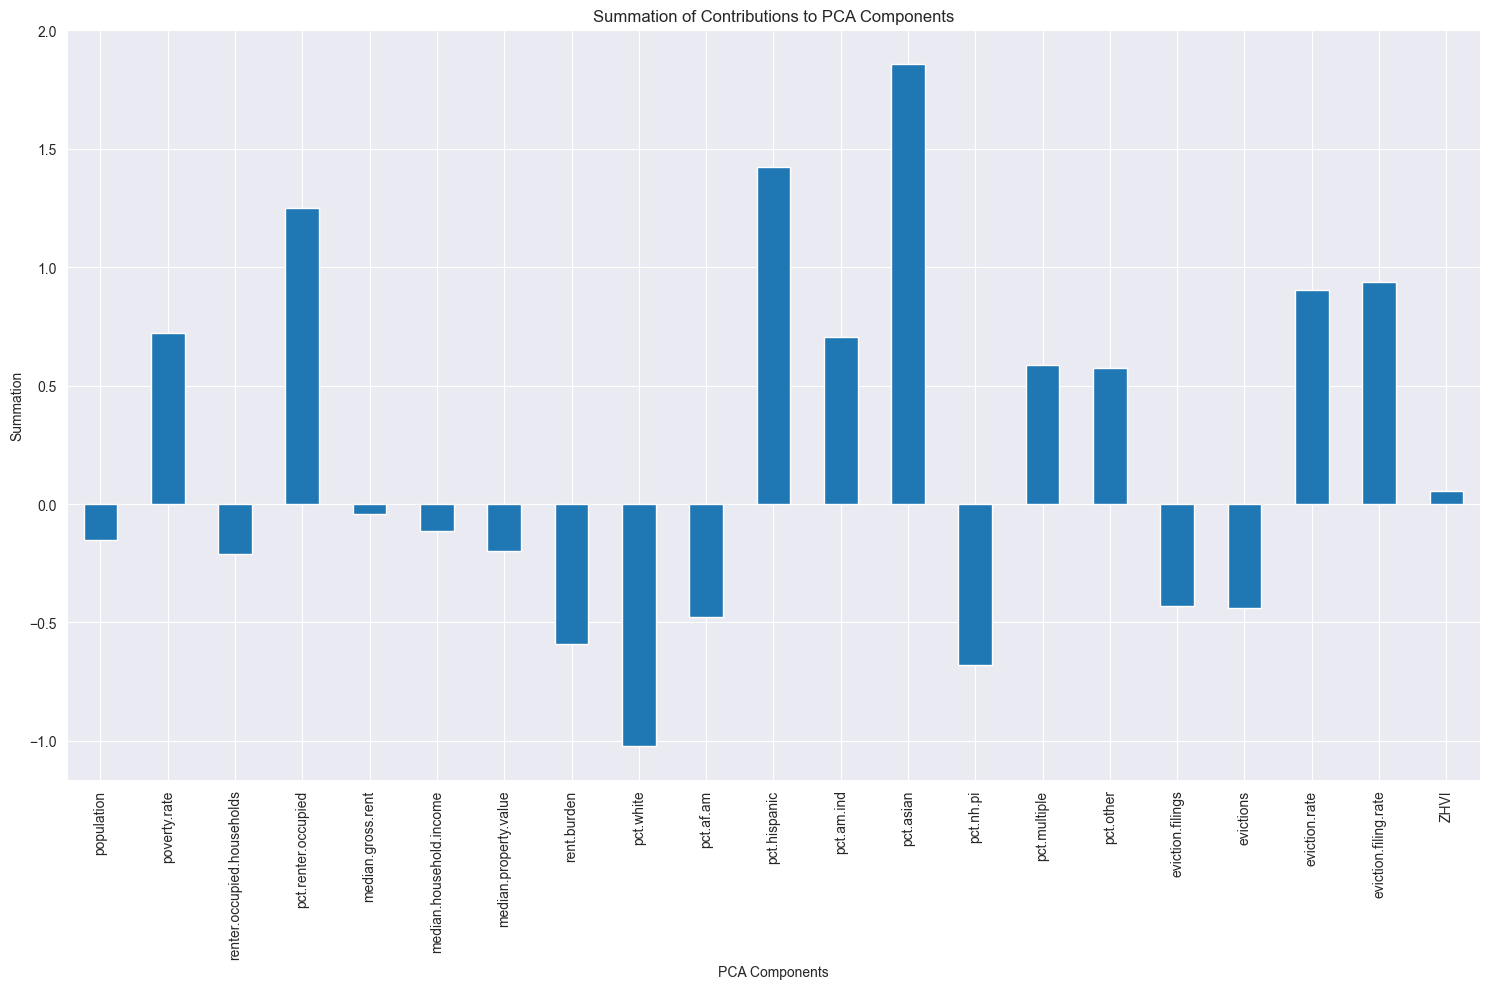

In [66]:
# Bar plot of the summation values

plt.figure(figsize=(15, 10))
column_sums.plot(kind='bar')
plt.title('Summation of Contributions to PCA Components')
plt.xlabel('PCA Components')
plt.ylabel('Summation')
plt.tight_layout()
plt.show()



In [59]:
    # Plot the SHAP values for a specific feature

# I want to have a table where each rows are for each PCA component and the columns are the original features. Each cell represents contribution of each original feature to each PCA component.




In [60]:

# LGBBM, RF, Naivae BAyes, LR


In [61]:
def explain_model_with_shap(model, X, pca_components, original_features, model_name):

    
    explainer = shap.TreeExplainer(model, X)
    shap_values = explainer(X)

    shap.summary_plot(shap_values, X, feature_names=[f'PCA_{i+1}' for i in range(X.shape[1])])
    shap.summary_plot(shap_values, X, plot_type='bar', feature_names=[f'PCA_{i+1}' for i in range(X.shape[1])])

    # Map top PCA components to original features
    for i, component in enumerate(pca_components[:13]):  # Top 13 PCA components
        print(f"PCA_{i+1} Contributions:")
        for j, feature in enumerate(original_features):
            print(f"{feature}: {component[j]:.4f}")
        print('\n')

    # Map PCA components to original features
    contributions = pd.DataFrame(pca_components.T, index=original_features, columns=[f'PCA_{i+1}' for i in range(pca_components.shape[0])])
    print("Contributions of Original Features to PCA Components:")
    print(contributions.head())

    # Map original features to PCA components 
    print(contributions.T.head())

    # Compute summation for each column in the transposed contributions table
    column_sums = contributions.T.sum(axis=0)

    # Display the results
    print("Summation for each column in contributions.T:")
    print(column_sums)

    # Bar plot of the summation values

    plt.figure(figsize=(12, 8))
    column_sums.plot(kind='bar')
    plt.title(f'Summation of Contributions to PCA Components for {model_name}')
    plt.xlabel('PCA Components')
    plt.ylabel('Summation')
    plt.tight_layout()
    plt.show()

    return None

In [62]:
# PCA-transformed dataset
X = data_preprocessed.drop(columns=['Classification']).values
y = data_preprocessed['Classification'].values
pca_components = pca.components_
original_features = ['population', 'poverty.rate',
       'renter.occupied.households', 'pct.renter.occupied',
       'median.gross.rent', 'median.household.income', 'median.property.value',
       'rent.burden', 'pct.white', 'pct.af.am', 'pct.hispanic', 'pct.am.ind',
       'pct.asian', 'pct.nh.pi', 'pct.multiple', 'pct.other',
       'eviction.filings', 'evictions', 'eviction.rate',
       'eviction.filing.rate',
       'ZHVI']



In [63]:
# # Pick one of your trained models (e.g., Random Forest) to explain its predictions.
# model = classifiers['Random Forest']  # Replace with the desired model
# 
# # # Run for each models in a loop
# # for model_name, model in classifiers.items():
# #     print(f"Explaining model: {model_name}")
# #     explain_model_with_shap(model, X, pca_components, original_features, model_name=model_name)
# 
# explain_model_with_shap(model, X, pca_components, original_features, model_name='Random Forest')